# Demo of the GTM on 10-Dimensional R-Vine-Copula Data

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 10 dimensional R-Vine-Copula as done in our [Paper](https://arxiv.org/pdf/2503.17845) Section 4.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [2]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv
# Helpers to generate specfific vines and analyze there conditional independencies
from pyvinecopulib_simulation_helpers import *

# Other Stuff
import numpy as np
import multiprocessing as mp
mp.set_start_method('spawn', force=True)
import torch
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
from sklearn.metrics import roc_auc_score, roc_curve

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
set_seeds(1)

### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a R-Vine-Copula and add Gaussian marginals. To create the Vine we use the functions `sample_random_pair_copulas`and `compute_conditional_dependence_table` from our helpers. Theses allow use to set independence copulas upon Tree 3 to add full conditional independencies as detailed in our Paper. The `df`contains a tables with the copulas, there parameters and there tree positions in a manner comparable to the conditional independence table later generated with the GTM.

In [4]:
D = 7  # dimension
rvine_structure = pv.RVineStructure.simulate(D)
pair_copulas = sample_random_pair_copulas(D,Independence_tree=3)
vine_model = pv.Vinecop.from_structure(structure=rvine_structure, pair_copulas=pair_copulas)
df = compute_conditional_dependence_table(vine_model)
#df

creating a table to compare the true dependence structure later on to what the gtm learned

In [5]:

df_true_structure = df[["tree","edge","conditioned variables", "conditioned variable 1", "conditioned variable 2", "dependence", "var_row", "var_col"]]
df_true_structure_sub = df_true_structure[["var_row", "var_col", "dependence"]]
df_true_structure_sub.loc[:, "var_row"] = df_true_structure_sub["var_row"] - 1
df_true_structure_sub.loc[:, "var_col"] = df_true_structure_sub["var_col"] - 1

The `pyvinecopulib`package offers to plot the tree structures:

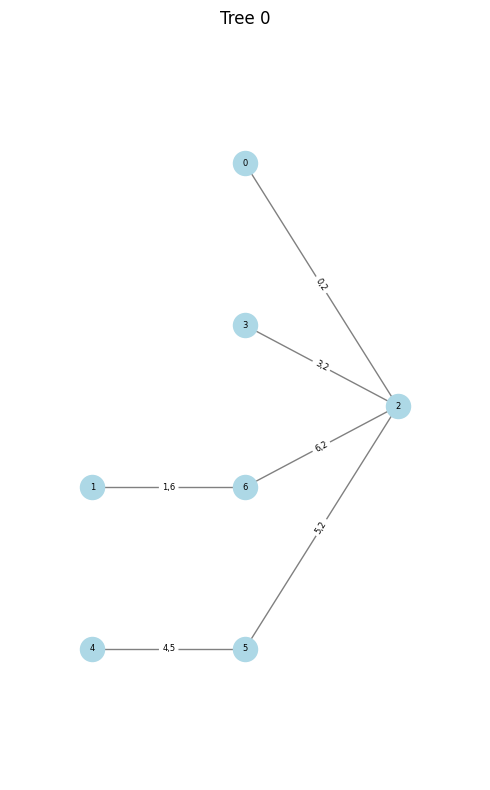

In [6]:
vine_model.plot(tree=[0])

In [7]:
# Train
N_train = 2000
simulated_data_uniform_train = vine_model.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = vine_model.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = vine_model.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [8]:
loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_train).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_validate).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_test).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [9]:
copula_pv_est = vine_model
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [10]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [11]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [12]:
model_freq = GTM(
        number_variables = D,
        number_transformation_layers = 1,
        number_decorrelation_layers= 3,
        degree_transformations = 15,
        degree_decorrelation = 30,
        spline_transformation = "bspline",
        spline_decorrelation = "bspline",
        transformation_spline_range = (-10, 10),
        device = "cuda" if torch.cuda.is_available() else "cpu")

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

In [13]:
#model_freq.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

In [14]:
#model_freq.plot_marginals(simulated_data_train)

### 3. Hyperparameter Tune and Train Model

#### 3.1 GTM

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [15]:
study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-12-08 14:26:44,551] A new study created in RDB with name: no-name-0c4bca75-8c31-4ab3-9669-504b8485a2fd
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:620: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ
  0%|          | 4/2000 [00:00<03:14, 10.25it/s]

current_loss: tensor(1.4415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4361845254898071
current_loss: tensor(1.4406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.432254433631897
current_loss: tensor(1.4364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4242960214614868
current_loss: tensor(1.4286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.8883, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4232170581817627


  0%|          | 7/2000 [00:00<02:09, 15.37it/s]

current_loss: tensor(1.4278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4224445819854736
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4221961498260498
current_loss: tensor(1.4266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4219458103179932
current_loss: tensor(1.4265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.421967625617981
current_loss: tensor(1.4265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4265, device='cuda:0', grad_fn=<MeanBackward0

  1%|          | 14/2000 [00:00<02:02, 16.26it/s]


current_loss: tensor(1.4264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4219753742218018
current_loss: tensor(1.4264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4220083951950073
current_loss: tensor(1.4264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4219999313354492
current_loss: tensor(1.4263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4221214056015015
current_loss: tensor(1.4262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4222240447998047
Early Stop at iteration 14 with minimal loss tensor(1.4219, device='cuda:0') and patience 5 and min_

  0%|          | 1/2000 [00:00<05:44,  5.80it/s]

current_loss: tensor(1.4285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3191076517105103
current_loss: tensor(1.3261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2005, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1852996349334717
current_loss: tensor(1.2005, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:52, 11.54it/s]

current_loss: tensor(1.3987, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.150647759437561
current_loss: tensor(1.1661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.14151132106781
current_loss: tensor(1.1572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1123278141021729


  0%|          | 7/2000 [00:00<02:49, 11.74it/s]

current_loss: tensor(1.1312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.104000210762024
current_loss: tensor(1.1235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0978609323501587
current_loss: tensor(1.1179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1062, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:46, 11.94it/s]

current_loss_val:  1.0825119018554688
current_loss: tensor(1.1062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1115, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1014, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.077195644378662
current_loss: tensor(1.1014, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0710442066192627
current_loss: tensor(1.0956, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:30,  9.43it/s]

current_loss: tensor(1.0784, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.048025369644165
current_loss: tensor(1.0784, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0757, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<05:22,  6.16it/s]

current_loss_val:  1.045729637145996
current_loss: tensor(1.0757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0348771810531616
current_loss: tensor(1.0610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0235849618911743
current_loss: tensor(1.0488, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:50,  8.62it/s]

current_loss: tensor(1.0440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0194684267044067
current_loss: tensor(1.0440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.014540195465088
current_loss: tensor(1.0346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0133963823318481


  1%|          | 19/2000 [00:02<03:21,  9.85it/s]

current_loss: tensor(1.0323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0120686292648315
current_loss: tensor(1.0305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0084869861602783
current_loss: tensor(1.0235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0058207511901855


  1%|          | 23/2000 [00:02<02:47, 11.80it/s]

current_loss: tensor(1.0206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0040870904922485
current_loss: tensor(1.0183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.002488136291504
current_loss: tensor(1.0167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0010803937911987


  1%|▏         | 25/2000 [00:02<02:38, 12.50it/s]

current_loss: tensor(1.0156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0002686977386475
current_loss: tensor(1.0149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9989521503448486
current_loss: tensor(1.0135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0125, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:38, 12.44it/s]

current_loss_val:  0.9989758729934692
current_loss: tensor(1.0125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9983603358268738
current_loss: tensor(1.0116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9967136979103088
current_loss: tensor(1.0096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0085, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:02<02:26, 13.44it/s]

current_loss_val:  0.9954118132591248
current_loss: tensor(1.0085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9937162399291992
current_loss: tensor(1.0070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9931884407997131
current_loss: tensor(1.0065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0048, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<02:23, 13.72it/s]

current_loss_val:  0.9913272857666016
current_loss: tensor(1.0048, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9891562461853027
current_loss: tensor(1.0031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0014, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9866446852684021
current_loss: tensor(1.0014, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0001, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:03<02:25, 13.47it/s]

current_loss_val:  0.9846828579902649
current_loss: tensor(1.0001, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9984, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9815312623977661
current_loss: tensor(0.9984, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0006, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9976, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9799665212631226
current_loss: tensor(0.9976, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:03<02:22, 13.72it/s]

current_loss: tensor(0.9968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9788112044334412
current_loss: tensor(0.9968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9765846133232117
current_loss: tensor(0.9956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9756277799606323
current_loss: tensor(0.9946, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:03<02:18, 14.10it/s]

current_loss: tensor(0.9931, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9741065502166748
current_loss: tensor(0.9931, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9704893231391907
current_loss: tensor(0.9912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9908, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9700990915298462
current_loss: tensor(0.9908, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:03<02:17, 14.20it/s]

current_loss: tensor(0.9901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9695008397102356
current_loss: tensor(0.9901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9693691730499268
current_loss: tensor(0.9897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9893, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9693025946617126
current_loss: tensor(0.9893, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:04<02:15, 14.40it/s]

current_loss: tensor(0.9880, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9695191979408264
current_loss: tensor(0.9880, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9875, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.970136821269989
current_loss: tensor(0.9875, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9871, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9697978496551514
current_loss: tensor(0.9871, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:04<02:49, 11.51it/s]


current_loss: tensor(0.9867, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9695239663124084
current_loss: tensor(0.9867, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9859, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9693353772163391
Early Stop at iteration 50 with minimal loss tensor(0.9693, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-08 14:26:52,430] Trial 0 finished with value: -6.785118103027344 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.216870023964308, 'penalty_decorrelation_ridge_second_difference': 12.8269755344816}. Best is trial 0 with value: -6.785118103027344.
  0%|          | 2/2000 [00:00<02:45, 12.04it/s]

current_loss: tensor(1.0141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0133, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.969622015953064
current_loss: tensor(1.0133, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9714401960372925
current_loss: tensor(1.0072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0096, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:43, 12.20it/s]

current_loss: tensor(1.0057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9712322950363159
current_loss: tensor(1.0057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0047, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9713021516799927
current_loss: tensor(1.0047, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0016, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9726821184158325
current_loss: tensor(1.0016, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:16, 10.16it/s]


current_loss: tensor(1.0035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0002, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9736644625663757
Early Stop at iteration 5 with minimal loss tensor(0.9696, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-08 14:26:53,484] Trial 1 finished with value: -6.787353992462158 and parameters: {'penalty_decorrelation_ridge_first_difference': 15.28540028350612, 'penalty_decorrelation_ridge_second_difference': 23.32356838814931}. Best is trial 0 with value: -6.785118103027344.
  0%|          | 2/2000 [00:00<02:21, 14.12it/s]

current_loss: tensor(1.0354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9694818258285522
current_loss: tensor(1.0338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9706504344940186
current_loss: tensor(1.0302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9759154319763184


  0%|          | 5/2000 [00:00<02:46, 11.98it/s]

current_loss: tensor(1.0246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9735755920410156
current_loss: tensor(1.0205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9734103679656982
current_loss: tensor(1.0192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9751163125038147
Early Stop at iteration 5 with minimal loss tensor(0.9695, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-08 14:26:54,523] Trial 2 finished with value: -6.786373138427734 and parameters: {'penalty_decorrelation_ridge_first_difference': 22.644317695451115, 'penalty_decorrelation_ridge_second_difference': 29.325758708272925}. Best is trial 0 with value: -6.785118103027344.
  0%|          | 1/2000 [00:00<03:20,  9.96it/s]

current_loss: tensor(0.9741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9691517949104309
current_loss: tensor(0.9739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.968530535697937
current_loss: tensor(0.9730, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:34, 12.93it/s]

current_loss: tensor(0.9718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9672608971595764
current_loss: tensor(0.9718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9669092893600464
current_loss: tensor(0.9711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9663521647453308
current_loss: tensor(0.9705, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:28, 13.42it/s]

current_loss: tensor(0.9695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9652478694915771
current_loss: tensor(0.9695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9647109508514404
current_loss: tensor(0.9690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.964399516582489
current_loss: tensor(0.9687, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:21, 14.02it/s]

current_loss: tensor(0.9686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9643445014953613
current_loss: tensor(0.9686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9642080068588257
current_loss: tensor(0.9683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9640182852745056
current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:00<02:20, 14.11it/s]

current_loss: tensor(0.9675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9635331630706787
current_loss: tensor(0.9675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9633187651634216
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.961773157119751
current_loss: tensor(0.9665, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<02:28, 13.37it/s]

current_loss: tensor(0.9663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9615570902824402
current_loss: tensor(0.9663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9612299203872681
current_loss: tensor(0.9660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9605366587638855
current_loss: tensor(0.9654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9642, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:35,  9.21it/s]

current_loss_val:  0.9589031934738159
current_loss: tensor(0.9642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9552453756332397
current_loss: tensor(0.9628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9535492658615112
current_loss: tensor(0.9621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9617, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:01<02:53, 11.38it/s]

current_loss_val:  0.9534218907356262
current_loss: tensor(0.9617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9534195065498352
current_loss: tensor(0.9615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9535666108131409
current_loss: tensor(0.9611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9625, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<02:49, 11.65it/s]

current_loss: tensor(0.9609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9537687301635742
current_loss: tensor(0.9609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9538243412971497
current_loss: tensor(0.9608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9539812803268433
current_loss: tensor(0.9606, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:47, 11.77it/s]


current_loss: tensor(0.9606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9541724324226379
Early Stop at iteration 26 with minimal loss tensor(0.9534, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-08 14:26:57,375] Trial 3 finished with value: -6.673936367034912 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.926790995935427, 'penalty_decorrelation_ridge_second_difference': 1.5589420453346998}. Best is trial 3 with value: -6.673936367034912.
  0%|          | 2/2000 [00:00<02:22, 14.06it/s]

current_loss: tensor(1.0144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9697005748748779
current_loss: tensor(1.0137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9695367217063904
current_loss: tensor(1.0129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9707831740379333


  0%|          | 6/2000 [00:00<02:19, 14.27it/s]

current_loss: tensor(1.0075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9732736945152283
current_loss: tensor(1.0061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9722260236740112
current_loss: tensor(1.0046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9719751477241516


  0%|          | 6/2000 [00:00<02:43, 12.16it/s]


current_loss: tensor(1.0039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9716473817825317
Early Stop at iteration 6 with minimal loss tensor(0.9695, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-08 14:26:58,465] Trial 4 finished with value: -6.786757469177246 and parameters: {'penalty_decorrelation_ridge_first_difference': 17.75955586471974, 'penalty_decorrelation_ridge_second_difference': 17.779420675546866}. Best is trial 3 with value: -6.673936367034912.
  0%|          | 2/2000 [00:00<03:11, 10.43it/s]

current_loss: tensor(0.9804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9691901803016663
current_loss: tensor(0.9802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9689053893089294
current_loss: tensor(0.9791, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:40, 12.45it/s]

current_loss: tensor(0.9782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9686214327812195
current_loss: tensor(0.9782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9683520197868347
current_loss: tensor(0.9775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.968191385269165
current_loss: tensor(0.9772, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:25, 13.65it/s]

current_loss: tensor(0.9765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9679049253463745
current_loss: tensor(0.9765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9683070778846741
current_loss: tensor(0.9763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9675521850585938
current_loss: tensor(0.9757, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:23, 13.88it/s]

current_loss: tensor(0.9756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9675083756446838
current_loss: tensor(0.9756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9673805832862854
current_loss: tensor(0.9754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9673384428024292


  1%|          | 12/2000 [00:00<02:38, 12.54it/s]

current_loss: tensor(0.9754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9670846462249756
current_loss: tensor(0.9751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9742, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9662712216377258
current_loss: tensor(0.9742, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9749, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:34, 12.86it/s]

current_loss: tensor(0.9738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9659660458564758
current_loss: tensor(0.9738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9653968214988708
current_loss: tensor(0.9732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9620415568351746
current_loss: tensor(0.9711, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:36, 12.67it/s]

current_loss: tensor(0.9718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9617948532104492
current_loss: tensor(0.9706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.961654543876648
current_loss: tensor(0.9701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9613674283027649


  1%|          | 20/2000 [00:01<02:42, 12.22it/s]

current_loss: tensor(0.9693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9607573747634888
current_loss: tensor(0.9682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9601574540138245
current_loss: tensor(0.9676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9671, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:29, 13.18it/s]

current_loss_val:  0.9597103595733643
current_loss: tensor(0.9671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9586554169654846
current_loss: tensor(0.9661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9579072594642639
current_loss: tensor(0.9656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9654, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:27, 13.35it/s]

current_loss_val:  0.9575112462043762
current_loss: tensor(0.9654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9564525485038757
current_loss: tensor(0.9649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.955626368522644
current_loss: tensor(0.9644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9639, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:21, 13.90it/s]

current_loss_val:  0.9550125598907471
current_loss: tensor(0.9639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.954568088054657
current_loss: tensor(0.9635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9536808133125305
current_loss: tensor(0.9626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9621, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:31, 12.97it/s]

current_loss_val:  0.9533302187919617
current_loss: tensor(0.9621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9530118703842163
current_loss: tensor(0.9618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9506233930587769
current_loss: tensor(0.9604, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:29, 13.12it/s]

current_loss: tensor(0.9618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9497369527816772
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9488086104393005
current_loss: tensor(0.9595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9462742805480957


  2%|▏         | 38/2000 [00:02<02:25, 13.46it/s]

current_loss: tensor(0.9583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.945568859577179
current_loss: tensor(0.9581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9455142617225647
current_loss: tensor(0.9578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.945667564868927


  2%|▏         | 40/2000 [00:03<02:22, 13.72it/s]

current_loss: tensor(0.9576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9458826184272766
current_loss: tensor(0.9574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9459405541419983
current_loss: tensor(0.9571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9568, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:33, 12.78it/s]

current_loss_val:  0.9458112120628357
current_loss: tensor(0.9568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9456544518470764
Early Stop at iteration 42 with minimal loss tensor(0.9455, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-08 14:27:02,366] Trial 5 finished with value: -6.618600368499756 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.420843387221027, 'penalty_decorrelation_ridge_second_difference': 14.280078786721484}. Best is trial 5 with value: -6.618600368499756.
  0%|          | 2/2000 [00:00<02:25, 13.72it/s]

current_loss: tensor(1.0175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.969810426235199
current_loss: tensor(1.0171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9694303870201111
current_loss: tensor(1.0163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9695107340812683


  0%|          | 6/2000 [00:00<02:20, 14.19it/s]

current_loss: tensor(1.0150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.969946563243866
current_loss: tensor(1.0135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0079, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.976259171962738
current_loss: tensor(1.0079, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9763850569725037


  0%|          | 6/2000 [00:00<02:45, 12.05it/s]


current_loss: tensor(1.0068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9751318097114563
Early Stop at iteration 6 with minimal loss tensor(0.9694, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-08 14:27:03,497] Trial 6 finished with value: -6.786012649536133 and parameters: {'penalty_decorrelation_ridge_first_difference': 22.918897206193837, 'penalty_decorrelation_ridge_second_difference': 9.09198244738078}. Best is trial 5 with value: -6.618600368499756.
  0%|          | 1/2000 [00:00<03:21,  9.92it/s]

current_loss: tensor(1.0018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0015, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.969253659248352
current_loss: tensor(1.0015, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0002, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.969214916229248
current_loss: tensor(1.0002, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:47, 11.88it/s]

current_loss: tensor(0.9972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9717921018600464
current_loss: tensor(0.9972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9978, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9959, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9716058969497681
current_loss: tensor(0.9959, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9952, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.971409022808075


  0%|          | 6/2000 [00:00<03:08, 10.59it/s]


current_loss: tensor(0.9952, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9712080955505371
current_loss: tensor(0.9943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9933, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9726510047912598
Early Stop at iteration 6 with minimal loss tensor(0.9692, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-08 14:27:04,746] Trial 7 finished with value: -6.784504413604736 and parameters: {'penalty_decorrelation_ridge_first_difference': 15.718799461460742, 'penalty_decorrelation_ridge_second_difference': 8.863067127100253}. Best is trial 5 with value: -6.618600368499756.
  0%|          | 2/2000 [00:00<02:28, 13.48it/s]

current_loss: tensor(1.0116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9696916341781616
current_loss: tensor(1.0109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0101, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9695307016372681
current_loss: tensor(1.0101, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0050, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9706132411956787


  0%|          | 6/2000 [00:00<02:21, 14.04it/s]

current_loss: tensor(1.0050, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0043, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9729878306388855
current_loss: tensor(1.0043, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9716587662696838
current_loss: tensor(1.0027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9714081883430481


  0%|          | 6/2000 [00:00<02:46, 11.98it/s]


current_loss: tensor(1.0021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9709169864654541
Early Stop at iteration 6 with minimal loss tensor(0.9695, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-08 14:27:05,862] Trial 8 finished with value: -6.786715030670166 and parameters: {'penalty_decorrelation_ridge_first_difference': 15.485535199920138, 'penalty_decorrelation_ridge_second_difference': 20.082026243175157}. Best is trial 5 with value: -6.618600368499756.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.0016, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0013, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<07:05,  4.70it/s]

current_loss_val:  0.9698600769042969
current_loss: tensor(1.0013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0007, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9693343043327332
current_loss: tensor(1.0007, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0002, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9692292809486389


  0%|          | 4/2000 [00:00<04:05,  8.12it/s]

current_loss: tensor(1.0002, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9998, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9693072438240051
current_loss: tensor(0.9998, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9698967337608337
current_loss: tensor(0.9967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9955, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<04:17,  7.73it/s]

current_loss_val:  0.9700821042060852
current_loss: tensor(0.9955, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9949, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9702156782150269
current_loss: tensor(0.9949, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9929, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9713909029960632
Early Stop at iteration 7 with minimal loss tensor(0.9692, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-08 14:27:07,432] Trial 9 finished with value: -6.784604549407959 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.526569381498351, 'penalty_decorrelation_ridge_second_difference': 18.44328584083892}. Best is trial 5 with value: -6.618600368499756.
  0%|          | 2/2000 [00:00<03:13, 10.32it/s]

current_loss: tensor(0.9756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9691601991653442
current_loss: tensor(0.9754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9686378836631775
current_loss: tensor(0.9746, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:46, 11.99it/s]

current_loss: tensor(0.9737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9675383567810059
current_loss: tensor(0.9737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9672179222106934
current_loss: tensor(0.9731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9668065309524536
current_loss: tensor(0.9727, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:38, 12.56it/s]

current_loss: tensor(0.9716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9657325744628906
current_loss: tensor(0.9716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9652135968208313
current_loss: tensor(0.9711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.964973509311676


  0%|          | 10/2000 [00:00<02:31, 13.10it/s]

current_loss: tensor(0.9709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9646835327148438
current_loss: tensor(0.9706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9641675353050232
current_loss: tensor(0.9699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9635713696479797


  1%|          | 14/2000 [00:01<02:24, 13.73it/s]

current_loss: tensor(0.9697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9631149172782898
current_loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9629111289978027
current_loss: tensor(0.9690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9625198841094971


  1%|          | 16/2000 [00:01<02:40, 12.33it/s]

current_loss: tensor(0.9687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9624953866004944
current_loss: tensor(0.9686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9624200463294983


  1%|          | 18/2000 [00:01<02:38, 12.49it/s]

current_loss: tensor(0.9685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9621649384498596
current_loss: tensor(0.9682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.961980938911438
current_loss: tensor(0.9680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9618712663650513


  1%|          | 22/2000 [00:01<02:28, 13.31it/s]

current_loss: tensor(0.9679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9618104100227356
current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9616611003875732
current_loss: tensor(0.9675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9615399837493896


  1%|          | 24/2000 [00:01<02:28, 13.33it/s]

current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9615941643714905
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9613709449768066
current_loss: tensor(0.9671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9670, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:25, 13.56it/s]

current_loss_val:  0.9613059759140015
current_loss: tensor(0.9670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9609767198562622
current_loss: tensor(0.9668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9608684778213501
current_loss: tensor(0.9667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9667, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:21, 13.94it/s]

current_loss_val:  0.9608163237571716
current_loss: tensor(0.9667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9607717394828796
current_loss: tensor(0.9667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.960728645324707
current_loss: tensor(0.9666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9665, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:20, 14.04it/s]

current_loss_val:  0.9605867862701416
current_loss: tensor(0.9665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9603709578514099
current_loss: tensor(0.9663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9600031971931458
current_loss: tensor(0.9659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9658, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:28, 13.24it/s]

current_loss_val:  0.9598499536514282
current_loss: tensor(0.9658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9585558772087097
current_loss: tensor(0.9647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.957738995552063
current_loss: tensor(0.9642, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:25, 13.52it/s]

current_loss: tensor(0.9636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9571484923362732
current_loss: tensor(0.9636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569317698478699
current_loss: tensor(0.9635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9563388824462891
current_loss: tensor(0.9631, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:22, 13.76it/s]

current_loss: tensor(0.9620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9544203281402588
current_loss: tensor(0.9620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9526232481002808
current_loss: tensor(0.9609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9508374333381653
current_loss: tensor(0.9598, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:20, 13.90it/s]

current_loss: tensor(0.9587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9492403864860535
current_loss: tensor(0.9587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9471879005432129
current_loss: tensor(0.9573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9457378387451172
current_loss: tensor(0.9567, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:18, 14.06it/s]

current_loss: tensor(0.9559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9446292519569397
current_loss: tensor(0.9559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9439963102340698
current_loss: tensor(0.9552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9439272284507751
current_loss: tensor(0.9551, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:03<02:18, 14.11it/s]

current_loss: tensor(0.9549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9437870383262634
current_loss: tensor(0.9549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9434023499488831
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9430879950523376
current_loss: tensor(0.9545, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:03<02:17, 14.20it/s]

current_loss: tensor(0.9543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9428815245628357
current_loss: tensor(0.9543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9429540038108826
current_loss: tensor(0.9541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9428695440292358
current_loss: tensor(0.9538, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:04<02:16, 14.24it/s]

current_loss: tensor(0.9533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9426910877227783
current_loss: tensor(0.9533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9430384039878845
current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9425493478775024
current_loss: tensor(0.9526, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:04<02:15, 14.27it/s]

current_loss: tensor(0.9524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9424214959144592
current_loss: tensor(0.9524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9424414038658142
current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9425606727600098
current_loss: tensor(0.9520, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:04<02:22, 13.58it/s]

current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9425681829452515
current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9423877596855164
current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9425552487373352


  3%|▎         | 66/2000 [00:04<02:18, 13.93it/s]

current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9423829317092896
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9423398375511169
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9421952962875366


  3%|▎         | 68/2000 [00:05<02:24, 13.38it/s]

current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9420838356018066
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9420391917228699
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 70/2000 [00:05<02:22, 13.56it/s]

current_loss_val:  0.9419978857040405
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9419527053833008
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9419777989387512
current_loss: tensor(0.9508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9508, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 74/2000 [00:05<02:18, 13.94it/s]

current_loss_val:  0.9419400095939636
current_loss: tensor(0.9508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9419257044792175
current_loss: tensor(0.9508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9419246315956116
current_loss: tensor(0.9508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9508, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 76/2000 [00:05<02:23, 13.37it/s]

current_loss: tensor(0.9508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9419733285903931
current_loss: tensor(0.9508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.941981315612793
current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9420110583305359
current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 78/2000 [00:05<02:23, 13.39it/s]

current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9421070218086243
current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9421201348304749
Early Stop at iteration 78 with minimal loss tensor(0.9419, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-08 14:27:13,843] Trial 10 finished with value: -6.593472480773926 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.07672850497419, 'penalty_decorrelation_ridge_second_difference': 5.17236622545276}. Best is trial 10 with value: -6.593472480773926.
  0%|          | 2/2000 [00:00<02:19, 14.33it/s]

current_loss: tensor(1.0308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9694905877113342
current_loss: tensor(1.0293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9704607129096985
current_loss: tensor(1.0262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9760822057723999


  0%|          | 5/2000 [00:00<02:47, 11.91it/s]

current_loss: tensor(1.0219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9729918241500854
current_loss: tensor(1.0174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9728156924247742
current_loss: tensor(1.0163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9742056131362915
Early Stop at iteration 5 with minimal loss tensor(0.9695, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-08 14:27:14,827] Trial 11 finished with value: -6.786433696746826 and parameters: {'penalty_decorrelation_ridge_first_difference': 20.28241522787351, 'penalty_decorrelation_ridge_second_difference': 29.824929524911852}. Best is trial 10 with value: -6.593472480773926.
  0%|          | 2/2000 [00:00<03:11, 10.42it/s]

current_loss: tensor(1.0117, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0113, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9693092107772827
current_loss: tensor(1.0113, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9696862101554871
current_loss: tensor(1.0080, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:40, 12.41it/s]

current_loss: tensor(1.0049, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9749060869216919
current_loss: tensor(1.0049, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9750909209251404
current_loss: tensor(1.0031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9737660884857178
current_loss: tensor(1.0018, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:08, 10.57it/s]


current_loss: tensor(1.0012, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9732467532157898
Early Stop at iteration 5 with minimal loss tensor(0.9693, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-08 14:27:15,929] Trial 12 finished with value: -6.7851643562316895 and parameters: {'penalty_decorrelation_ridge_first_difference': 21.711530022663414, 'penalty_decorrelation_ridge_second_difference': 5.5762793315408725}. Best is trial 10 with value: -6.593472480773926.
  0%|          | 2/2000 [00:00<02:26, 13.68it/s]

current_loss: tensor(0.9944, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9698604941368103
current_loss: tensor(0.9942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9693058133125305
current_loss: tensor(0.9936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9691964983940125


  0%|          | 4/2000 [00:00<02:24, 13.79it/s]

current_loss: tensor(0.9932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9929, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9692437052726746
current_loss: tensor(0.9929, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9905, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9695358872413635
current_loss: tensor(0.9905, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9895, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:50, 11.67it/s]

current_loss_val:  0.9696305990219116
current_loss: tensor(0.9895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9890, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9697054028511047
current_loss: tensor(0.9890, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9874, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9703190326690674
Early Stop at iteration 7 with minimal loss tensor(0.9692, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-08 14:27:17,115] Trial 13 finished with value: -6.7843756675720215 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.570720358763793, 'penalty_decorrelation_ridge_second_difference': 22.279907145260726}. Best is trial 10 with value: -6.593472480773926.
  0%|          | 1/2000 [00:00<03:23,  9.83it/s]

current_loss: tensor(0.9977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9982, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9975, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9692025780677795
current_loss: tensor(0.9975, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9973, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9966, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9690154790878296
current_loss: tensor(0.9966, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:48, 11.83it/s]

current_loss: tensor(0.9939, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9699429273605347
current_loss: tensor(0.9939, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9947, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9930, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.970077633857727
current_loss: tensor(0.9930, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9924, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.969821572303772


  0%|          | 6/2000 [00:00<03:17, 10.11it/s]


current_loss: tensor(0.9924, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.969394862651825
current_loss: tensor(0.9907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9900, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9693042635917664
Early Stop at iteration 6 with minimal loss tensor(0.9690, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-08 14:27:18,312] Trial 14 finished with value: -6.783108234405518 and parameters: {'penalty_decorrelation_ridge_first_difference': 17.429970111805588, 'penalty_decorrelation_ridge_second_difference': 0.37950075626588237}. Best is trial 10 with value: -6.593472480773926.
  0%|          | 1/2000 [00:00<03:22,  9.86it/s]

current_loss: tensor(0.9717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9724, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9691638946533203
current_loss: tensor(0.9716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9688458442687988
current_loss: tensor(0.9711, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:17, 10.09it/s]

current_loss: tensor(0.9699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9676448106765747
current_loss: tensor(0.9699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9673900604248047
current_loss: tensor(0.9694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9690, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:58, 11.17it/s]

current_loss_val:  0.9670962691307068
current_loss: tensor(0.9690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9659957885742188
current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9654110074043274
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:45, 12.06it/s]

current_loss: tensor(0.9670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9651205539703369
current_loss: tensor(0.9670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9647729992866516
current_loss: tensor(0.9666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9644819498062134
current_loss: tensor(0.9661, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:30, 13.18it/s]

current_loss: tensor(0.9658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9639267325401306
current_loss: tensor(0.9658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9635019898414612
current_loss: tensor(0.9654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9626466035842896
current_loss: tensor(0.9649, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<02:33, 12.96it/s]

current_loss: tensor(0.9641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.961222767829895
current_loss: tensor(0.9641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9612632393836975
current_loss: tensor(0.9639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9635, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<02:38, 12.51it/s]

current_loss_val:  0.9606026411056519
current_loss: tensor(0.9635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9602115750312805
current_loss: tensor(0.9632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9601075649261475
current_loss: tensor(0.9631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9625, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<02:36, 12.68it/s]

current_loss_val:  0.9603291153907776
current_loss: tensor(0.9625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9601170420646667
current_loss: tensor(0.9623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9599071741104126
current_loss: tensor(0.9621, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:01<02:31, 13.09it/s]

current_loss: tensor(0.9617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9594814777374268
current_loss: tensor(0.9617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9590651392936707
current_loss: tensor(0.9611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9589405059814453


  1%|▏         | 27/2000 [00:02<02:30, 13.15it/s]

current_loss: tensor(0.9609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.958823025226593
current_loss: tensor(0.9608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9585840702056885
current_loss: tensor(0.9607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9579408168792725


  1%|▏         | 29/2000 [00:02<02:26, 13.46it/s]

current_loss: tensor(0.9604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9575589895248413
current_loss: tensor(0.9603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9574376344680786
current_loss: tensor(0.9602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9574328660964966


  2%|▏         | 31/2000 [00:02<02:24, 13.59it/s]

current_loss: tensor(0.9601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9574914574623108
current_loss: tensor(0.9599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9575329422950745
current_loss: tensor(0.9598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9598, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:02<02:33, 12.81it/s]

current_loss_val:  0.9575203061103821
current_loss: tensor(0.9598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9575085043907166
current_loss: tensor(0.9594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.95737224817276
current_loss: tensor(0.9593, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:02<02:35, 12.59it/s]

current_loss: tensor(0.9593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9568675756454468
current_loss: tensor(0.9590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9561582207679749
current_loss: tensor(0.9588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9560506343841553


  2%|▏         | 41/2000 [00:03<02:26, 13.34it/s]

current_loss: tensor(0.9587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9559741616249084
current_loss: tensor(0.9586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9558236598968506
current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9559593200683594


  2%|▏         | 43/2000 [00:03<02:23, 13.61it/s]

current_loss: tensor(0.9581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9557027220726013
current_loss: tensor(0.9579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9553428888320923
current_loss: tensor(0.9577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9549704194068909


  2%|▏         | 45/2000 [00:03<02:29, 13.08it/s]

current_loss: tensor(0.9575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9548000693321228
current_loss: tensor(0.9574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9547261595726013
current_loss: tensor(0.9573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9571, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:03<02:23, 13.57it/s]

current_loss_val:  0.9543747305870056
current_loss: tensor(0.9571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.953870952129364
current_loss: tensor(0.9569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9529393315315247
current_loss: tensor(0.9563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9557, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:03<02:22, 13.65it/s]

current_loss_val:  0.95184725522995
current_loss: tensor(0.9557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9502061009407043
current_loss: tensor(0.9549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.949144184589386
current_loss: tensor(0.9544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9541, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:04<02:20, 13.86it/s]

current_loss_val:  0.9487947821617126
current_loss: tensor(0.9541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9485068917274475
current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9481814503669739
current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9528, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 57/2000 [00:04<02:19, 13.94it/s]

current_loss_val:  0.9477715492248535
current_loss: tensor(0.9528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.947024941444397
current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9461751580238342
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 61/2000 [00:04<02:30, 12.90it/s]

current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9454758763313293
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.943069338798523
current_loss: tensor(0.9497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9430480003356934


  3%|▎         | 63/2000 [00:04<02:25, 13.27it/s]

current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9427207708358765
current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.941261351108551
current_loss: tensor(0.9470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9468, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 65/2000 [00:05<02:30, 12.83it/s]

current_loss_val:  0.9411072731018066
current_loss: tensor(0.9468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.940912127494812
current_loss: tensor(0.9465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9404674768447876
current_loss: tensor(0.9461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9462, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 69/2000 [00:05<02:28, 13.02it/s]

current_loss: tensor(0.9460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9402010440826416
current_loss: tensor(0.9460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9401294589042664
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9401000142097473
current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 71/2000 [00:05<02:24, 13.38it/s]

current_loss: tensor(0.9455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9404343962669373
current_loss: tensor(0.9455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9403518438339233
current_loss: tensor(0.9452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9402487874031067
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 75/2000 [00:05<02:19, 13.76it/s]

current_loss: tensor(0.9448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9401270747184753
current_loss: tensor(0.9448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9399926066398621
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9399442076683044
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 77/2000 [00:05<02:18, 13.87it/s]

current_loss: tensor(0.9443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9397308826446533
current_loss: tensor(0.9443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9396252632141113
current_loss: tensor(0.9443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9395714998245239
current_loss: tensor(0.9442, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 81/2000 [00:06<02:16, 14.02it/s]

current_loss: tensor(0.9442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9395955801010132
current_loss: tensor(0.9442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.939751923084259
current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9397876858711243
current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 82/2000 [00:06<02:27, 12.99it/s]


current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9398096203804016
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9402012228965759
Early Stop at iteration 82 with minimal loss tensor(0.9396, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-08 14:27:25,254] Trial 15 finished with value: -6.577001094818115 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.8812712777510949, 'penalty_decorrelation_ridge_second_difference': 10.818151605794938}. Best is trial 15 with value: -6.577001094818115.
  0%|          | 1/2000 [00:00<03:21,  9.90it/s]

current_loss: tensor(0.9716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9691629409790039
current_loss: tensor(0.9715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9707, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9686644673347473
current_loss: tensor(0.9707, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:38, 12.56it/s]

current_loss: tensor(0.9698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9676130414009094
current_loss: tensor(0.9698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9672748446464539
current_loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9669243693351746
current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:41, 12.34it/s]

current_loss: tensor(0.9676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9658219218254089
current_loss: tensor(0.9676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9653318524360657
current_loss: tensor(0.9671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.965080201625824


  1%|          | 11/2000 [00:00<02:29, 13.30it/s]

current_loss: tensor(0.9669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9646870493888855
current_loss: tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9642423391342163
current_loss: tensor(0.9658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9635482430458069


  1%|          | 13/2000 [00:01<02:26, 13.57it/s]

current_loss: tensor(0.9655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9631429314613342
current_loss: tensor(0.9652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9628191590309143
current_loss: tensor(0.9649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9623258709907532


  1%|          | 15/2000 [00:01<02:32, 13.01it/s]

current_loss: tensor(0.9645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9623737335205078
current_loss: tensor(0.9643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9623152017593384


  1%|          | 19/2000 [00:01<02:35, 12.72it/s]

current_loss: tensor(0.9642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9621090292930603
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9619362950325012
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9617084264755249


  1%|          | 21/2000 [00:01<02:30, 13.13it/s]

current_loss: tensor(0.9637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9616981148719788
current_loss: tensor(0.9636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9616800546646118
current_loss: tensor(0.9634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9633, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:01<02:36, 12.66it/s]

current_loss_val:  0.961551308631897
current_loss: tensor(0.9633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9614818692207336
current_loss: tensor(0.9633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9614531397819519
current_loss: tensor(0.9632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9630, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:27, 13.35it/s]

current_loss_val:  0.9614561200141907
current_loss: tensor(0.9630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9613209962844849
current_loss: tensor(0.9628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9609891772270203
current_loss: tensor(0.9625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9629, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<02:32, 12.94it/s]

current_loss: tensor(0.9615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9594846367835999
current_loss: tensor(0.9615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9574185013771057
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9516756534576416
current_loss: tensor(0.9571, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:02<02:30, 13.06it/s]

current_loss: tensor(0.9576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9500037431716919
current_loss: tensor(0.9554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9481421709060669
current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9476940631866455


  2%|▏         | 35/2000 [00:02<02:36, 12.54it/s]

current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9475054740905762
current_loss: tensor(0.9530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9473970532417297
current_loss: tensor(0.9528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:02<02:33, 12.79it/s]

current_loss_val:  0.9465665221214294
current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9465217590332031
current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.94640052318573
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:03<02:27, 13.32it/s]

current_loss_val:  0.9463168382644653
current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9461309313774109
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9460985064506531
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9461354613304138
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:03<03:19,  9.82it/s]

current_loss_val:  0.9462734460830688
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9462457895278931
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9461882710456848
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:03<02:45, 11.84it/s]


current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9461032748222351
Early Stop at iteration 45 with minimal loss tensor(0.9461, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-08 14:27:29,753] Trial 16 finished with value: -6.622689247131348 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.9871237309986469, 'penalty_decorrelation_ridge_second_difference': 10.459546158754183}. Best is trial 15 with value: -6.577001094818115.
  0%|          | 2/2000 [00:00<02:25, 13.75it/s]

current_loss: tensor(0.9843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9842, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9698697328567505
current_loss: tensor(0.9842, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9692580699920654
current_loss: tensor(0.9835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9691503643989563


  0%|          | 4/2000 [00:00<02:24, 13.80it/s]

current_loss: tensor(0.9833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9691618084907532
current_loss: tensor(0.9830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.969211220741272
current_loss: tensor(0.9814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9880, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9804, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:50, 11.67it/s]

current_loss_val:  0.9691785573959351
current_loss: tensor(0.9804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9691582918167114
current_loss: tensor(0.9799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9692212343215942
Early Stop at iteration 7 with minimal loss tensor(0.9692, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-08 14:27:30,979] Trial 17 finished with value: -6.78405237197876 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.22857289383361845, 'penalty_decorrelation_ridge_second_difference': 26.105155452155184}. Best is trial 15 with value: -6.577001094818115.
  0%|          | 1/2000 [00:00<03:25,  9.75it/s]

current_loss: tensor(0.9848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9854, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9691767692565918
current_loss: tensor(0.9846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9845, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9688034057617188
current_loss: tensor(0.9837, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:38, 12.60it/s]

current_loss: tensor(0.9826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9682819843292236
current_loss: tensor(0.9826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9682084321975708
current_loss: tensor(0.9819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9678261876106262
current_loss: tensor(0.9814, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:31, 13.18it/s]

current_loss: tensor(0.9804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9671178460121155
current_loss: tensor(0.9804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9671947360038757
current_loss: tensor(0.9800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9667601585388184
current_loss: tensor(0.9796, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:34, 12.86it/s]

current_loss: tensor(0.9795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.966720700263977
current_loss: tensor(0.9795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9666856527328491
current_loss: tensor(0.9793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9666010141372681


  1%|          | 13/2000 [00:01<02:30, 13.21it/s]

current_loss: tensor(0.9791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9665370583534241
current_loss: tensor(0.9791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9664576053619385
current_loss: tensor(0.9789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9665210843086243


  1%|          | 15/2000 [00:01<02:27, 13.42it/s]

current_loss: tensor(0.9788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9662335515022278
current_loss: tensor(0.9785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9784, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9660781025886536
current_loss: tensor(0.9784, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<02:38, 12.55it/s]

current_loss: tensor(0.9782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9658135175704956
current_loss: tensor(0.9782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9656400680541992
current_loss: tensor(0.9780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9655579328536987


  1%|          | 21/2000 [00:01<02:35, 12.76it/s]

current_loss: tensor(0.9778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9654723405838013
current_loss: tensor(0.9777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9653429985046387
current_loss: tensor(0.9772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9650532603263855


  1%|          | 23/2000 [00:01<02:29, 13.23it/s]

current_loss: tensor(0.9767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9645670652389526
current_loss: tensor(0.9760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9627915620803833
current_loss: tensor(0.9743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9728, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:30, 13.08it/s]

current_loss_val:  0.9611808657646179
current_loss: tensor(0.9728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9592653512954712
current_loss: tensor(0.9712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.958335816860199
current_loss: tensor(0.9706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9704, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<02:27, 13.35it/s]

current_loss_val:  0.9579522609710693
current_loss: tensor(0.9704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9565420746803284
current_loss: tensor(0.9695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9557381272315979
current_loss: tensor(0.9691, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:02<02:36, 12.59it/s]

current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9552633762359619
current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9538060426712036
current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9536113142967224


  2%|▏         | 35/2000 [00:02<02:30, 13.03it/s]

current_loss: tensor(0.9677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9530525207519531
current_loss: tensor(0.9672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9519112706184387
current_loss: tensor(0.9666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9510350227355957


  2%|▏         | 39/2000 [00:03<02:25, 13.52it/s]

current_loss: tensor(0.9660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9491183161735535
current_loss: tensor(0.9653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9480881094932556
current_loss: tensor(0.9648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9471445083618164


  2%|▏         | 41/2000 [00:03<02:22, 13.71it/s]

current_loss: tensor(0.9643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9459970593452454
current_loss: tensor(0.9639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9450532793998718
current_loss: tensor(0.9634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9444659352302551


  2%|▏         | 45/2000 [00:03<02:20, 13.88it/s]

current_loss: tensor(0.9630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9440814852714539
current_loss: tensor(0.9627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9438177347183228
current_loss: tensor(0.9624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9438244700431824


  2%|▏         | 47/2000 [00:03<02:20, 13.94it/s]

current_loss: tensor(0.9622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9434953331947327
current_loss: tensor(0.9619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9433441162109375
current_loss: tensor(0.9618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.943129301071167


  3%|▎         | 51/2000 [00:03<02:19, 13.99it/s]

current_loss: tensor(0.9615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9430631995201111
current_loss: tensor(0.9612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.942798376083374
current_loss: tensor(0.9610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9425853490829468


  3%|▎         | 53/2000 [00:04<02:25, 13.36it/s]

current_loss: tensor(0.9608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9422967433929443
current_loss: tensor(0.9606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9423424005508423
current_loss: tensor(0.9603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:04<02:24, 13.46it/s]

current_loss_val:  0.9419435858726501
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9417819380760193
current_loss: tensor(0.9597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9416570663452148
current_loss: tensor(0.9596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9595, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 59/2000 [00:04<02:21, 13.71it/s]

current_loss_val:  0.941664457321167
current_loss: tensor(0.9595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9417897462844849
current_loss: tensor(0.9593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9419301152229309
current_loss: tensor(0.9591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9591, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:04<02:29, 12.98it/s]


current_loss: tensor(0.9588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9418047070503235
current_loss: tensor(0.9588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9418976306915283
Early Stop at iteration 60 with minimal loss tensor(0.9417, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-08 14:27:36,199] Trial 18 finished with value: -6.591599941253662 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.508940688195537, 'penalty_decorrelation_ridge_second_difference': 4.843091241430226}. Best is trial 15 with value: -6.577001094818115.
  0%|          | 2/2000 [00:00<03:29,  9.52it/s]

current_loss: tensor(0.9636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9691361784934998
current_loss: tensor(0.9634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9683175086975098


  0%|          | 4/2000 [00:00<02:48, 11.86it/s]

current_loss: tensor(0.9622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9667776823043823
current_loss: tensor(0.9604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9663331508636475
current_loss: tensor(0.9594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9586, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:39, 12.49it/s]

current_loss_val:  0.9654802083969116
current_loss: tensor(0.9586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9642824530601501
current_loss: tensor(0.9575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9635607004165649
current_loss: tensor(0.9567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9563, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:29, 13.32it/s]

current_loss_val:  0.9632384181022644
current_loss: tensor(0.9563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9631678462028503
current_loss: tensor(0.9561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9626153707504272
current_loss: tensor(0.9551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9549, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:26, 13.56it/s]

current_loss_val:  0.962079644203186
current_loss: tensor(0.9549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9605864882469177
current_loss: tensor(0.9533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9602117538452148
current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9526, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:32, 13.05it/s]

current_loss_val:  0.9599031805992126
current_loss: tensor(0.9526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9589781761169434
current_loss: tensor(0.9521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9586377143859863
current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:32, 13.03it/s]

current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9585860371589661
current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9585511088371277
current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9585756063461304
current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:28, 13.34it/s]

current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9585860371589661
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9582619071006775
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9578247666358948
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:27, 13.39it/s]

current_loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9568260312080383
current_loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9550970196723938
current_loss: tensor(0.9486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9533213973045349
current_loss: tensor(0.9476, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:24, 13.67it/s]

current_loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9512578248977661
current_loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9499614834785461
current_loss: tensor(0.9462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9485470056533813
current_loss: tensor(0.9447, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:23, 13.74it/s]

current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9483542442321777
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9479264616966248
current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9475083351135254
current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:22, 13.84it/s]

current_loss: tensor(0.9429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9469782114028931
current_loss: tensor(0.9429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9467699527740479
current_loss: tensor(0.9425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9466403126716614
current_loss: tensor(0.9423, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:28, 13.25it/s]

current_loss: tensor(0.9420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9464874267578125
current_loss: tensor(0.9420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9463320970535278
current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9462396502494812


  2%|▏         | 40/2000 [00:03<02:24, 13.53it/s]

current_loss: tensor(0.9412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9459481835365295
current_loss: tensor(0.9410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9457728266716003
current_loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9457632303237915


  2%|▏         | 42/2000 [00:03<02:23, 13.67it/s]

current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9456692934036255
current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9452126026153564
current_loss: tensor(0.9400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:30, 13.03it/s]

current_loss_val:  0.9451096653938293
current_loss: tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9450666308403015
current_loss: tensor(0.9398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9446086883544922
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9393, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:29, 13.04it/s]

current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9445714354515076
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9445186257362366
current_loss: tensor(0.9390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9445801973342896
current_loss: tensor(0.9388, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:03<02:26, 13.35it/s]

current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.944677472114563
current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.944531261920929
current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.944267988204956
current_loss: tensor(0.9381, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:04<02:30, 12.95it/s]

current_loss: tensor(0.9377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.943605899810791
current_loss: tensor(0.9377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9434044361114502
current_loss: tensor(0.9375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9430292248725891


  3%|▎         | 56/2000 [00:04<02:26, 13.31it/s]

current_loss: tensor(0.9372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9411923289299011
current_loss: tensor(0.9362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9413391351699829
current_loss: tensor(0.9359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9409319162368774


  3%|▎         | 60/2000 [00:04<02:22, 13.60it/s]

current_loss: tensor(0.9354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9406800866127014
current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9405148029327393
current_loss: tensor(0.9349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9405096173286438


  3%|▎         | 62/2000 [00:04<02:27, 13.15it/s]

current_loss: tensor(0.9348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9406035542488098
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9405613541603088
current_loss: tensor(0.9344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9342, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:04<02:26, 13.19it/s]

current_loss_val:  0.9404559135437012
current_loss: tensor(0.9342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9402915835380554
current_loss: tensor(0.9339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9399977326393127
current_loss: tensor(0.9336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 68/2000 [00:05<02:23, 13.50it/s]

current_loss_val:  0.9397222399711609
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9390751719474792
current_loss: tensor(0.9328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9386159181594849
current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 70/2000 [00:05<02:19, 13.79it/s]

current_loss_val:  0.9383654594421387
current_loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9382480978965759
current_loss: tensor(0.9321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.937903881072998
current_loss: tensor(0.9316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 74/2000 [00:05<02:24, 13.30it/s]

current_loss: tensor(0.9313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9375717043876648
current_loss: tensor(0.9313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9374171495437622
current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9372822046279907
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 76/2000 [00:05<02:22, 13.48it/s]

current_loss: tensor(0.9303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9369641542434692
current_loss: tensor(0.9303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9365882277488708
current_loss: tensor(0.9299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9362890124320984
current_loss: tensor(0.9296, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 80/2000 [00:06<02:20, 13.67it/s]

current_loss: tensor(0.9294, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.93636155128479
current_loss: tensor(0.9294, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9361798167228699
current_loss: tensor(0.9292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.936075747013092
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 82/2000 [00:06<02:18, 13.81it/s]

current_loss: tensor(0.9288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.936019241809845
current_loss: tensor(0.9288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9361931681632996
current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9359594583511353
current_loss: tensor(0.9285, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 86/2000 [00:06<02:18, 13.85it/s]

current_loss: tensor(0.9285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9357803463935852
current_loss: tensor(0.9285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9355937242507935
current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9353976845741272
current_loss: tensor(0.9281, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 88/2000 [00:06<02:24, 13.21it/s]

current_loss: tensor(0.9281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9354748129844666
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9353920817375183
current_loss: tensor(0.9277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9352080225944519


  5%|▍         | 92/2000 [00:06<02:20, 13.58it/s]

current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9354650378227234
current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9352329969406128
current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9351328611373901


  5%|▍         | 94/2000 [00:07<02:25, 13.07it/s]

current_loss: tensor(0.9271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350271821022034
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350135326385498
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 96/2000 [00:07<02:23, 13.24it/s]

current_loss_val:  0.9349627494812012
current_loss: tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.934909462928772
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9349238276481628
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 100/2000 [00:07<02:24, 13.13it/s]

current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9349247217178345
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9349209666252136
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9349319934844971
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 102/2000 [00:07<02:21, 13.40it/s]

current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9348344206809998
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9348575472831726
current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9348718523979187
current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 105/2000 [00:07<02:23, 13.22it/s]

current_loss: tensor(0.9264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9349458813667297
current_loss: tensor(0.9264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350460171699524
current_loss: tensor(0.9264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9349895119667053
Early Stop at iteration 105 with minimal loss tensor(0.9348, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-08 14:27:44,766] Trial 19 finished with value: -6.5438408851623535 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.5742065114469581, 'penalty_decorrelation_ridge_second_difference': 2.586041171345979}. Best is trial 19 with value: -6.5438408851623535.
  0%|          | 2/2000 [00:00<03:13, 10.32it/s]

current_loss: tensor(0.9644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9691344499588013
current_loss: tensor(0.9642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9682742357254028
current_loss: tensor(0.9629, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:47, 11.89it/s]

current_loss: tensor(0.9606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9669752717018127
current_loss: tensor(0.9606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9666686058044434
current_loss: tensor(0.9594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9655142426490784
current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:32, 13.08it/s]

current_loss: tensor(0.9568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9640074968338013
current_loss: tensor(0.9568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9632067680358887
current_loss: tensor(0.9559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9628644585609436
current_loss: tensor(0.9553, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:29, 13.35it/s]

current_loss: tensor(0.9550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.962782621383667
current_loss: tensor(0.9550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9623119235038757
current_loss: tensor(0.9536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.961859941482544


  1%|          | 14/2000 [00:01<02:31, 13.11it/s]

current_loss: tensor(0.9530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9611918330192566
current_loss: tensor(0.9524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9589648246765137
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9578416347503662


  1%|          | 16/2000 [00:01<02:39, 12.47it/s]

current_loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9566835761070251
current_loss: tensor(0.9489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9563668966293335
current_loss: tensor(0.9486, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:39, 12.46it/s]

current_loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9561205506324768
current_loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9558110237121582
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9550408720970154
current_loss: tensor(0.9472, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:31, 13.09it/s]

current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9546138048171997
current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9544445872306824
current_loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9541165232658386
current_loss: tensor(0.9463, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:28, 13.34it/s]

current_loss: tensor(0.9460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9540377855300903
current_loss: tensor(0.9460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9539409875869751
current_loss: tensor(0.9460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9537698030471802
current_loss: tensor(0.9458, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:32, 12.96it/s]

current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9536414742469788
current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9534833431243896
current_loss: tensor(0.9456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9534022212028503


  2%|▏         | 30/2000 [00:02<02:28, 13.24it/s]

current_loss: tensor(0.9455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9533127546310425
current_loss: tensor(0.9455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9530591368675232
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9529085159301758


  2%|▏         | 34/2000 [00:02<02:25, 13.54it/s]

current_loss: tensor(0.9450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9528929591178894
current_loss: tensor(0.9449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9525761008262634
current_loss: tensor(0.9447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9525173306465149


  2%|▏         | 36/2000 [00:02<02:33, 12.82it/s]

current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9520003199577332
current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9514268636703491
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9438, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:30, 13.00it/s]

current_loss_val:  0.9512879848480225
current_loss: tensor(0.9438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9512349367141724
current_loss: tensor(0.9437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9511957168579102
current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9434, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:26, 13.32it/s]

current_loss_val:  0.951231837272644
current_loss: tensor(0.9434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9513078927993774
current_loss: tensor(0.9433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9512633085250854
current_loss: tensor(0.9432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9426, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:24, 13.52it/s]

current_loss_val:  0.9511356353759766
current_loss: tensor(0.9426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9501212239265442
current_loss: tensor(0.9418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9488561749458313
current_loss: tensor(0.9406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:22, 13.67it/s]

current_loss_val:  0.9477233290672302
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9468774199485779
current_loss: tensor(0.9393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9461400508880615
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9381, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:03<02:20, 13.89it/s]

current_loss_val:  0.9451692700386047
current_loss: tensor(0.9381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.944705069065094
current_loss: tensor(0.9376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.944472074508667
current_loss: tensor(0.9375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:04<02:28, 13.11it/s]

current_loss_val:  0.9440853595733643
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9436798095703125
current_loss: tensor(0.9362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9434966444969177
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:04<02:32, 12.75it/s]

current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9433480501174927
current_loss: tensor(0.9354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9432333707809448
current_loss: tensor(0.9353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9426189064979553


  3%|▎         | 58/2000 [00:04<02:36, 12.38it/s]

current_loss: tensor(0.9347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9425618648529053
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9424992799758911
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:04<02:28, 13.07it/s]

current_loss_val:  0.9421801567077637
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9418473243713379
current_loss: tensor(0.9340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9418041110038757
current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9336, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:04<02:25, 13.35it/s]

current_loss_val:  0.9418230056762695
current_loss: tensor(0.9336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9418742656707764
current_loss: tensor(0.9334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9419525861740112
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9331, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 66/2000 [00:05<02:29, 12.93it/s]

current_loss_val:  0.9420632719993591
current_loss: tensor(0.9331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9419020414352417
Early Stop at iteration 66 with minimal loss tensor(0.9418, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-08 14:27:50,474] Trial 20 finished with value: -6.5926289558410645 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.9026329645791489, 'penalty_decorrelation_ridge_second_difference': 0.3816690722641223}. Best is trial 19 with value: -6.5438408851623535.
  0%|          | 2/2000 [00:00<03:10, 10.48it/s]

current_loss: tensor(0.9893, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9898, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9891, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9691898822784424
current_loss: tensor(0.9891, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9890, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9884, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9689823985099792
current_loss: tensor(0.9884, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:56, 11.34it/s]

current_loss: tensor(0.9866, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9689052700996399
current_loss: tensor(0.9866, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9868, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9689069986343384
current_loss: tensor(0.9860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.968681812286377


  0%|          | 6/2000 [00:00<02:43, 12.20it/s]

current_loss: tensor(0.9855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9841, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9681693315505981
current_loss: tensor(0.9841, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9864, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9680003523826599
current_loss: tensor(0.9835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9833, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:38, 12.54it/s]

current_loss_val:  0.9678892493247986
current_loss: tensor(0.9833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9680485129356384
current_loss: tensor(0.9829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.968508243560791
current_loss: tensor(0.9825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9822, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<02:51, 11.60it/s]

current_loss_val:  0.9688593745231628
current_loss: tensor(0.9822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9686182141304016
current_loss: tensor(0.9819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9683311581611633
Early Stop at iteration 12 with minimal loss tensor(0.9679, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-08 14:27:52,157] Trial 21 finished with value: -6.775224685668945 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.084377651704553, 'penalty_decorrelation_ridge_second_difference': 6.046360140139207}. Best is trial 19 with value: -6.5438408851623535.
  0%|          | 2/2000 [00:00<03:15, 10.23it/s]

current_loss: tensor(0.9724, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.969158411026001
current_loss: tensor(0.9723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9688143134117126
current_loss: tensor(0.9718, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:01, 11.00it/s]

current_loss: tensor(0.9705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9674465656280518
current_loss: tensor(0.9705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9671672582626343
current_loss: tensor(0.9701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9697, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:46, 12.00it/s]

current_loss_val:  0.9668201804161072
current_loss: tensor(0.9697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9654541015625
current_loss: tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9707, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9649245142936707
current_loss: tensor(0.9679, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:39, 12.51it/s]

current_loss: tensor(0.9677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9646390676498413
current_loss: tensor(0.9677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9641711711883545
current_loss: tensor(0.9672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9637860059738159
current_loss: tensor(0.9667, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:33, 12.93it/s]

current_loss: tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9631749391555786
current_loss: tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9627252817153931
current_loss: tensor(0.9660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9620957374572754
current_loss: tensor(0.9656, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:36, 12.72it/s]

current_loss: tensor(0.9648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9608282446861267
current_loss: tensor(0.9648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9606110453605652
current_loss: tensor(0.9646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9605202674865723


  1%|          | 18/2000 [00:01<02:31, 13.12it/s]

current_loss: tensor(0.9645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9594922065734863
current_loss: tensor(0.9636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.958198070526123
current_loss: tensor(0.9630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9572638869285583


  1%|          | 20/2000 [00:01<02:27, 13.39it/s]

current_loss: tensor(0.9625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.956696093082428
current_loss: tensor(0.9620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9535320997238159
current_loss: tensor(0.9606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:31, 13.01it/s]

current_loss_val:  0.9530236124992371
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9529179334640503
current_loss: tensor(0.9598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9525503516197205
current_loss: tensor(0.9591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9583, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:27, 13.35it/s]

current_loss_val:  0.9516068696975708
current_loss: tensor(0.9583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9508999586105347
current_loss: tensor(0.9577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9502198696136475
current_loss: tensor(0.9571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9561, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:26, 13.46it/s]

current_loss_val:  0.9484660029411316
current_loss: tensor(0.9561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9470136761665344
current_loss: tensor(0.9556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9461718797683716
current_loss: tensor(0.9550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9548, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:24, 13.58it/s]

current_loss_val:  0.9458900690078735
current_loss: tensor(0.9548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9451555609703064
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9447438716888428
current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9534, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:33, 12.77it/s]

current_loss_val:  0.9442877769470215
current_loss: tensor(0.9534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9439464211463928
current_loss: tensor(0.9530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9433242082595825
current_loss: tensor(0.9523, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:30, 13.04it/s]

current_loss: tensor(0.9521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9426413178443909
current_loss: tensor(0.9521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9424821734428406
current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9424624443054199
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:34, 12.70it/s]

current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9424340128898621
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9422639608383179
current_loss: tensor(0.9508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9422198534011841


  2%|▏         | 44/2000 [00:03<02:31, 12.91it/s]

current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9422867298126221
current_loss: tensor(0.9503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9422038793563843
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9498, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<02:27, 13.21it/s]

current_loss_val:  0.94216388463974
current_loss: tensor(0.9498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9427900314331055
current_loss: tensor(0.9497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9423950910568237
current_loss: tensor(0.9494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9494, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:04<04:21,  7.46it/s]

current_loss_val:  0.9422808885574341
current_loss: tensor(0.9494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9421489238739014
current_loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9421514868736267


  3%|▎         | 52/2000 [00:04<03:44,  8.67it/s]

current_loss: tensor(0.9491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.942254364490509
current_loss: tensor(0.9491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9421675205230713
current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.942103922367096


  3%|▎         | 54/2000 [00:04<03:24,  9.51it/s]

current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9420552849769592
current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9419702291488647
current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:05<02:56, 11.02it/s]

current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9420459866523743
current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9420919418334961
current_loss: tensor(0.9487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9421837329864502
current_loss: tensor(0.9485, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:05<02:53, 11.17it/s]

current_loss: tensor(0.9485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9420538544654846
current_loss: tensor(0.9482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9419680237770081
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.941984236240387


  3%|▎         | 62/2000 [00:05<02:51, 11.32it/s]

current_loss: tensor(0.9475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9420090317726135
current_loss: tensor(0.9474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9420360326766968
current_loss: tensor(0.9472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9470, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:05<02:49, 11.45it/s]

current_loss_val:  0.9421587586402893
current_loss: tensor(0.9470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9423321485519409
Early Stop at iteration 64 with minimal loss tensor(0.9420, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-08 14:27:58,335] Trial 22 finished with value: -6.593776226043701 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.720268515521835, 'penalty_decorrelation_ridge_second_difference': 7.240727704923875}. Best is trial 19 with value: -6.5438408851623535.
  0%|          | 2/2000 [00:00<03:12, 10.36it/s]

current_loss: tensor(0.9759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9691823124885559
current_loss: tensor(0.9757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9688317179679871
current_loss: tensor(0.9747, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:47, 11.92it/s]

current_loss: tensor(0.9739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9683067202568054
current_loss: tensor(0.9739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9680079817771912


  0%|          | 6/2000 [00:00<04:19,  7.69it/s]

current_loss: tensor(0.9732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9678511619567871
current_loss: tensor(0.9729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9675252437591553
current_loss: tensor(0.9722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9724, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9717, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:24,  9.73it/s]

current_loss_val:  0.967200756072998
current_loss: tensor(0.9717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.967045247554779
current_loss: tensor(0.9715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9713, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9669890403747559
current_loss: tensor(0.9713, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9709, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:01, 10.94it/s]

current_loss_val:  0.967052698135376
current_loss: tensor(0.9709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9667216539382935
current_loss: tensor(0.9706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9664660692214966
current_loss: tensor(0.9703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9687, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<02:49, 11.72it/s]

current_loss_val:  0.9646435379981995
current_loss: tensor(0.9687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9641090631484985
current_loss: tensor(0.9683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9637887477874756
current_loss: tensor(0.9680, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<02:40, 12.35it/s]

current_loss: tensor(0.9676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9632209539413452
current_loss: tensor(0.9676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9620711803436279
current_loss: tensor(0.9674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9614843130111694
current_loss: tensor(0.9666, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<02:34, 12.79it/s]

current_loss: tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9614855647087097
current_loss: tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9615740776062012
current_loss: tensor(0.9659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9656, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<02:34, 12.81it/s]

current_loss_val:  0.9614609479904175
current_loss: tensor(0.9656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9614401459693909
current_loss: tensor(0.9655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9614711403846741
current_loss: tensor(0.9654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9651, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<02:30, 13.14it/s]

current_loss_val:  0.9616224765777588
current_loss: tensor(0.9651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9614568948745728
current_loss: tensor(0.9649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.961287260055542
current_loss: tensor(0.9648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9656, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<02:32, 12.94it/s]

current_loss: tensor(0.9644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9606897234916687
current_loss: tensor(0.9644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9600863456726074
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9598369002342224
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:02<02:29, 13.21it/s]

current_loss: tensor(0.9638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9595850706100464
current_loss: tensor(0.9638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9591252207756042
current_loss: tensor(0.9637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9636, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:02<02:37, 12.47it/s]

current_loss_val:  0.9590470194816589
current_loss: tensor(0.9636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9590478539466858
current_loss: tensor(0.9636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9590857028961182
current_loss: tensor(0.9634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9630, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:03<02:39, 12.29it/s]

current_loss_val:  0.9589641094207764
current_loss: tensor(0.9630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9588529467582703
current_loss: tensor(0.9629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9587424397468567
current_loss: tensor(0.9628, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:03<02:41, 12.14it/s]

current_loss: tensor(0.9622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9579363465309143
current_loss: tensor(0.9622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9577363133430481
current_loss: tensor(0.9621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9574970602989197


  2%|▏         | 43/2000 [00:03<02:31, 12.89it/s]

current_loss: tensor(0.9619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9568706750869751
current_loss: tensor(0.9615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9566251039505005
current_loss: tensor(0.9614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9564887881278992


  2%|▏         | 45/2000 [00:03<02:42, 12.04it/s]

current_loss: tensor(0.9612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9558223485946655
current_loss: tensor(0.9605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9543526768684387
current_loss: tensor(0.9598, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:03<02:38, 12.35it/s]

current_loss: tensor(0.9593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9537374377250671
current_loss: tensor(0.9593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9534246325492859
current_loss: tensor(0.9589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9530465602874756
current_loss: 

  2%|▏         | 49/2000 [00:04<02:32, 12.75it/s]

tensor(0.9583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9526241421699524
current_loss: tensor(0.9578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9518512487411499
current_loss: tensor(0.9569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9498196244239807


  3%|▎         | 53/2000 [00:04<02:26, 13.25it/s]

current_loss: tensor(0.9558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9483357071876526
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9476426839828491
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9536, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:04<02:30, 12.95it/s]

current_loss_val:  0.9465369582176208
current_loss: tensor(0.9536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9457582831382751
current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.944490909576416
current_loss: tensor(0.9520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9515, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 59/2000 [00:04<02:34, 12.56it/s]

current_loss_val:  0.9433736205101013
current_loss: tensor(0.9515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9430626034736633
current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.942976713180542


  3%|▎         | 61/2000 [00:05<02:37, 12.29it/s]

current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9424088001251221
current_loss: tensor(0.9503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9420223236083984
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 63/2000 [00:05<02:34, 12.53it/s]

current_loss_val:  0.9416706562042236
current_loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9412003755569458
current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9409610033035278
current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 67/2000 [00:05<02:28, 13.03it/s]

current_loss_val:  0.9407790303230286
current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9405257701873779
current_loss: tensor(0.9487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9405397772789001
current_loss: tensor(0.9486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 69/2000 [00:05<02:23, 13.44it/s]

current_loss_val:  0.9406896233558655
current_loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9407349824905396
current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9408140778541565
current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 70/2000 [00:05<02:39, 12.13it/s]


current_loss_val:  0.9407152533531189
Early Stop at iteration 70 with minimal loss tensor(0.9405, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-08 14:28:04,663] Trial 23 finished with value: -6.583680629730225 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.9566013598850516, 'penalty_decorrelation_ridge_second_difference': 15.166092120303102}. Best is trial 19 with value: -6.5438408851623535.
  0%|          | 2/2000 [00:00<03:11, 10.45it/s]

current_loss: tensor(0.9799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.969211757183075
current_loss: tensor(0.9796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9690260291099548
current_loss: tensor(0.9782, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:43, 12.19it/s]

current_loss: tensor(0.9777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9691001772880554
current_loss: tensor(0.9777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9685372114181519
current_loss: tensor(0.9767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9685173034667969
current_loss: tensor(0.9764, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:34, 12.87it/s]

current_loss: tensor(0.9761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9684372544288635
current_loss: tensor(0.9761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9681961536407471
current_loss: tensor(0.9759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9757, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:34, 12.87it/s]

current_loss_val:  0.9680936932563782
current_loss: tensor(0.9757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9680435061454773
current_loss: tensor(0.9754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9682925343513489
current_loss: tensor(0.9753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9750, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:30, 13.18it/s]

current_loss_val:  0.9680968523025513
current_loss: tensor(0.9750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9679460525512695
current_loss: tensor(0.9748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9673982858657837
current_loss: tensor(0.9740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9741, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:33, 12.93it/s]

current_loss: tensor(0.9731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9670696258544922
current_loss: tensor(0.9731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9669157862663269
current_loss: tensor(0.9728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9667404294013977
current_loss: tensor(0.9725, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:30, 13.16it/s]

current_loss: tensor(0.9718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9661075472831726
current_loss: tensor(0.9718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9657288789749146
current_loss: tensor(0.9714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9648265838623047
current_loss: tensor(0.9704, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:27, 13.42it/s]

current_loss: tensor(0.9700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.964695394039154
current_loss: tensor(0.9700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9646409153938293
current_loss: tensor(0.9697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9646667838096619
current_loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:32, 12.92it/s]

current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9641739726066589
current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9637677073478699
current_loss: tensor(0.9685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9632542729377747


  1%|▏         | 28/2000 [00:02<02:28, 13.29it/s]

current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9630635976791382
current_loss: tensor(0.9679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9629735946655273
current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9627366065979004


  2%|▏         | 30/2000 [00:02<02:25, 13.49it/s]

current_loss: tensor(0.9676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9625813364982605
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9626997113227844
current_loss: tensor(0.9672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9671, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:36, 12.57it/s]

current_loss_val:  0.962611734867096
current_loss: tensor(0.9671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9622530341148376
current_loss: tensor(0.9668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9615200757980347
current_loss: tensor(0.9665, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:32, 12.86it/s]

current_loss: tensor(0.9660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9610254764556885
current_loss: tensor(0.9660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9601321816444397
current_loss: tensor(0.9654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9583130478858948


  2%|▏         | 38/2000 [00:02<02:29, 13.14it/s]

current_loss: tensor(0.9647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9570202231407166
current_loss: tensor(0.9644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9568758010864258
current_loss: tensor(0.9642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9567883610725403


  2%|▏         | 42/2000 [00:03<02:22, 13.72it/s]

current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9564103484153748
current_loss: tensor(0.9637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.95562344789505
current_loss: tensor(0.9633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9547330141067505


  2%|▏         | 44/2000 [00:03<02:27, 13.25it/s]

current_loss: tensor(0.9627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.951337456703186
current_loss: tensor(0.9615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9502608776092529
current_loss: tensor(0.9609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9602, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<02:27, 13.21it/s]

current_loss_val:  0.9498635530471802
current_loss: tensor(0.9602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9499450325965881
current_loss: tensor(0.9597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9503542184829712
current_loss: tensor(0.9590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9638, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:03<02:33, 12.75it/s]

current_loss: tensor(0.9589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9504572749137878
current_loss: tensor(0.9589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9504751563072205
current_loss: tensor(0.9588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9506925940513611
Early Stop at iteration 49 with minimal loss tensor(0.9499, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-08 14:28:09,105] Trial 24 finished with value: -6.649044990539551 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.9660595167342524, 'penalty_decorrelation_ridge_second_difference': 19.5266107094705}. Best is trial 19 with value: -6.5438408851623535.
  0%|          | 2/2000 [00:00<03:12, 10.36it/s]

current_loss: tensor(0.9728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9691712856292725
current_loss: tensor(0.9726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9687563180923462
current_loss: tensor(0.9718, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:45, 12.06it/s]

current_loss: tensor(0.9709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9679167866706848
current_loss: tensor(0.9709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9676681160926819
current_loss: tensor(0.9703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9673877358436584
current_loss: tensor(0.9700, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:33, 12.99it/s]

current_loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9668039679527283
current_loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9664918184280396
current_loss: tensor(0.9686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9661777019500732
current_loss: tensor(0.9683, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:32, 13.03it/s]

current_loss: tensor(0.9682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9661226272583008
current_loss: tensor(0.9682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9659829139709473
current_loss: tensor(0.9679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.965940535068512
current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:28, 13.36it/s]

current_loss: tensor(0.9675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9656680822372437
current_loss: tensor(0.9675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9655675292015076
current_loss: tensor(0.9675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9654515981674194
current_loss: tensor(0.9674, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:27, 13.48it/s]

current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9652501344680786
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9651603698730469
current_loss: tensor(0.9672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9650383591651917
current_loss: tensor(0.9671, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:25, 13.58it/s]

current_loss: tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9640017151832581
current_loss: tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9630205631256104
current_loss: tensor(0.9654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9623166918754578
current_loss: tensor(0.9647, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:32, 12.99it/s]

current_loss: tensor(0.9626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9598146080970764
current_loss: tensor(0.9626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9555529356002808
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9592, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:29, 13.20it/s]

current_loss_val:  0.9538882970809937
current_loss: tensor(0.9592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.953194260597229
current_loss: tensor(0.9588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9512251019477844
current_loss: tensor(0.9586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9577, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:28, 13.24it/s]

current_loss_val:  0.9505447745323181
current_loss: tensor(0.9577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9505105018615723
current_loss: tensor(0.9576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9503440260887146
current_loss: tensor(0.9567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9555, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:32, 12.95it/s]

current_loss_val:  0.9496446847915649
current_loss: tensor(0.9555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9490934014320374
current_loss: tensor(0.9551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9488045573234558
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:30, 13.04it/s]

current_loss: tensor(0.9539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9484665989875793
current_loss: tensor(0.9539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.948354959487915
current_loss: tensor(0.9536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9483005404472351


  2%|▏         | 36/2000 [00:02<02:40, 12.23it/s]

current_loss: tensor(0.9534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9480952620506287
current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9474857449531555
current_loss: tensor(0.9531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9526, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:34, 12.70it/s]

current_loss_val:  0.9471613168716431
current_loss: tensor(0.9526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9471534490585327
current_loss: tensor(0.9524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9471468925476074
current_loss: tensor(0.9520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:43, 12.01it/s]

current_loss_val:  0.9469280242919922
current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9468405842781067
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9468474984169006


  2%|▏         | 44/2000 [00:03<02:45, 11.85it/s]

current_loss: tensor(0.9515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9469473958015442
current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9469476938247681
current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<02:40, 12.20it/s]

current_loss_val:  0.9468993544578552
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9467632174491882
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9466047883033752
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:03<02:31, 12.89it/s]

current_loss_val:  0.9465916752815247
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9466032385826111
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9466157555580139
current_loss: tensor(0.9508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:04<02:26, 13.33it/s]

current_loss_val:  0.9465513229370117
current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9466845393180847
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9464475512504578
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:04<02:26, 13.24it/s]

current_loss_val:  0.9463989734649658
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9463891983032227
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9463860988616943
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:04<02:31, 12.78it/s]

current_loss: tensor(0.9503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9463838338851929
current_loss: tensor(0.9503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9463759064674377
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9462575316429138
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:04<02:27, 13.18it/s]

current_loss: tensor(0.9495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.945702075958252
current_loss: tensor(0.9495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9452171921730042
current_loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9449185132980347
current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:04<02:24, 13.37it/s]

current_loss: tensor(0.9486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9448607563972473
current_loss: tensor(0.9486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9448676705360413
current_loss: tensor(0.9482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9445880651473999
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 68/2000 [00:05<02:23, 13.43it/s]

current_loss: tensor(0.9477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.944501519203186
current_loss: tensor(0.9477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9443865418434143
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9444094300270081
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 70/2000 [00:05<02:20, 13.71it/s]

current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9441693425178528
current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9440927505493164
current_loss: tensor(0.9470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9440263509750366
current_loss: tensor(0.9470, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 74/2000 [00:05<02:22, 13.52it/s]

current_loss: tensor(0.9469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9440799951553345
current_loss: tensor(0.9469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9439807534217834
current_loss: tensor(0.9469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9439395666122437
current_loss: 

  4%|▍         | 76/2000 [00:05<02:21, 13.61it/s]

tensor(0.9469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9438456892967224
current_loss: tensor(0.9468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9437960386276245
current_loss: tensor(0.9468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9438037872314453


  4%|▍         | 78/2000 [00:05<02:20, 13.69it/s]

current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9437372088432312
current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9436911940574646
current_loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9465, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 82/2000 [00:06<02:27, 13.00it/s]

current_loss_val:  0.9436753392219543
current_loss: tensor(0.9465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9436454772949219
current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9435608386993408
current_loss: tensor(0.9462, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 84/2000 [00:06<02:24, 13.23it/s]

current_loss: tensor(0.9460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9435023665428162
current_loss: tensor(0.9460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9433196187019348
current_loss: tensor(0.9458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9426461458206177
current_loss: tensor(0.9456, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 88/2000 [00:06<02:22, 13.39it/s]

current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.942310631275177
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9422751069068909
current_loss: tensor(0.9452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.942268967628479
current_loss: tensor(0.9450, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 90/2000 [00:06<02:21, 13.47it/s]

current_loss: tensor(0.9449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9421921372413635
current_loss: tensor(0.9449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9421216249465942
current_loss: tensor(0.9448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9420913457870483
current_loss: tensor(0.9447, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 94/2000 [00:07<02:21, 13.50it/s]

current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9419639706611633
current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9418303370475769
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9417260885238647
current_loss: tensor(0.9444, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 96/2000 [00:07<02:28, 12.83it/s]

current_loss: tensor(0.9443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9416634440422058
current_loss: tensor(0.9443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.94181889295578
current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9417693614959717


  5%|▍         | 98/2000 [00:07<02:24, 13.16it/s]

current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9416816234588623
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9415772557258606
current_loss: tensor(0.9438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9438, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 102/2000 [00:07<02:28, 12.78it/s]

current_loss: tensor(0.9437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9414598345756531
current_loss: tensor(0.9437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9414103031158447
current_loss: tensor(0.9437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.941265881061554
current_loss: tensor(0.9436, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 104/2000 [00:07<02:25, 13.06it/s]

current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9412096738815308
current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9410411715507507
current_loss: tensor(0.9434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.940960168838501
current_loss: tensor(0.9433, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 108/2000 [00:08<02:22, 13.25it/s]

current_loss: tensor(0.9432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9408918023109436
current_loss: tensor(0.9432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9406375885009766
current_loss: tensor(0.9431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9405616521835327
current_loss: tensor(0.9430, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 110/2000 [00:08<02:20, 13.43it/s]

current_loss: tensor(0.9430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.940578818321228
current_loss: tensor(0.9430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9406939148902893
current_loss: tensor(0.9428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9405587315559387
current_loss: tensor(0.9425, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 114/2000 [00:08<02:19, 13.48it/s]

current_loss: tensor(0.9421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9401777386665344
current_loss: tensor(0.9421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9395719766616821
current_loss: tensor(0.9416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9390806555747986
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 116/2000 [00:08<02:19, 13.55it/s]

current_loss: tensor(0.9412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9389790892601013
current_loss: tensor(0.9412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.938818097114563
current_loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9384959936141968
current_loss: tensor(0.9404, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 118/2000 [00:09<02:27, 12.77it/s]

current_loss: tensor(0.9455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9384511709213257
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9384617805480957
current_loss: tensor(0.9402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9385319352149963


  6%|▌         | 122/2000 [00:09<02:27, 12.69it/s]

current_loss: tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9383766651153564
current_loss: tensor(0.9398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.938349187374115
current_loss: tensor(0.9398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 124/2000 [00:09<02:22, 13.18it/s]

current_loss_val:  0.9383524060249329
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9383852481842041
current_loss: tensor(0.9396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9383413791656494
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 128/2000 [00:09<02:27, 12.67it/s]

current_loss_val:  0.9382121562957764
current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9382749795913696
current_loss: tensor(0.9393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9382690787315369
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 130/2000 [00:09<02:24, 12.98it/s]

current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9382094144821167
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9381653666496277
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9383959174156189
current_loss: tensor(0.9390, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 134/2000 [00:10<02:20, 13.27it/s]

current_loss: tensor(0.9390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9382210969924927
current_loss: tensor(0.9390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9381812214851379
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9380744695663452
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 136/2000 [00:10<02:19, 13.36it/s]

current_loss: tensor(0.9388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9379575848579407
current_loss: tensor(0.9388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9378787279129028
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.937744140625
current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 140/2000 [00:10<02:18, 13.46it/s]

current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9376729130744934
current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9376857876777649
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9379364848136902
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 142/2000 [00:10<02:16, 13.58it/s]

current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9378114938735962
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9377686977386475
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9376384615898132
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 146/2000 [00:11<02:16, 13.59it/s]

current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9375799298286438
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9375963807106018
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9376958608627319


  7%|▋         | 148/2000 [00:11<02:15, 13.66it/s]

current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9377070069313049
current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9377259016036987
current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 148/2000 [00:11<02:21, 13.05it/s]


current_loss_val:  0.9377419948577881
Early Stop at iteration 148 with minimal loss tensor(0.9376, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-08 14:28:21,004] Trial 25 finished with value: -6.5630598068237305 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.27550629584443864, 'penalty_decorrelation_ridge_second_difference': 13.391806767923338}. Best is trial 19 with value: -6.5438408851623535.
  0%|          | 2/2000 [00:00<03:12, 10.38it/s]

current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9691489934921265
current_loss: tensor(0.9676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9685054421424866
current_loss: tensor(0.9668, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:46, 12.02it/s]

current_loss: tensor(0.9657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9670754075050354
current_loss: tensor(0.9657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9666346907615662
current_loss: tensor(0.9650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9661356806755066
current_loss: tensor(0.9645, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:34, 12.91it/s]

current_loss: tensor(0.9634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9648891091346741
current_loss: tensor(0.9634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9643799662590027
current_loss: tensor(0.9631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9639017581939697
current_loss: tensor(0.9625, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:30, 13.21it/s]

current_loss: tensor(0.9624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9638691544532776
current_loss: tensor(0.9624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9638680219650269
current_loss: tensor(0.9622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9637038111686707


  1%|          | 14/2000 [00:01<02:32, 13.04it/s]

current_loss: tensor(0.9621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9635986089706421
current_loss: tensor(0.9620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9633378982543945
current_loss: tensor(0.9616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9629870653152466


  1%|          | 16/2000 [00:01<02:45, 11.97it/s]

current_loss: tensor(0.9614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9626719951629639
current_loss: tensor(0.9611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9622737765312195
current_loss: tensor(0.9608, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:49, 11.68it/s]

current_loss: tensor(0.9605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9618346095085144
current_loss: tensor(0.9605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9613701105117798
current_loss: tensor(0.9603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:43, 12.09it/s]

current_loss_val:  0.9610944390296936
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9588178396224976
current_loss: tensor(0.9587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9573553204536438


  1%|          | 22/2000 [00:01<02:45, 11.95it/s]

current_loss: tensor(0.9577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9556690454483032
current_loss: tensor(0.9564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9517106413841248
current_loss: tensor(0.9543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9535, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:34, 12.74it/s]

current_loss_val:  0.9503121972084045
current_loss: tensor(0.9535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9493910074234009
current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9478182792663574
current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9520, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:31, 13.02it/s]

current_loss_val:  0.9472338557243347
current_loss: tensor(0.9520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9470419883728027
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9470917582511902
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:27, 13.30it/s]

current_loss_val:  0.9473530650138855
current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9476108551025391
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.947481095790863
current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:40, 12.28it/s]


current_loss_val:  0.9475235939025879
Early Stop at iteration 32 with minimal loss tensor(0.9470, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-08 14:28:24,279] Trial 26 finished with value: -6.629293918609619 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.0050316254284506, 'penalty_decorrelation_ridge_second_difference': 6.210326959106526}. Best is trial 19 with value: -6.5438408851623535.
  0%|          | 2/2000 [00:00<03:12, 10.36it/s]

current_loss: tensor(0.9897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9902, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9692118763923645
current_loss: tensor(0.9895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9893, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9881, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9690786600112915
current_loss: tensor(0.9881, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:45, 12.07it/s]

current_loss: tensor(0.9869, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9695883393287659
current_loss: tensor(0.9869, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9859, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9693955779075623
current_loss: tensor(0.9859, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9691503047943115
current_loss: tensor(0.9855, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:34, 12.88it/s]

current_loss: tensor(0.9848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9688786864280701
current_loss: tensor(0.9848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9688901901245117
current_loss: tensor(0.9840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9687589406967163
current_loss: tensor(0.9837, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:30, 13.20it/s]

current_loss: tensor(0.9836, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9687665700912476
current_loss: tensor(0.9836, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9688780307769775
current_loss: tensor(0.9829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9688366055488586


  1%|          | 12/2000 [00:01<03:53,  8.52it/s]

current_loss: tensor(0.9824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.968755304813385
current_loss: tensor(0.9821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9685985445976257
current_loss: tensor(0.9816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9810, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:12, 10.31it/s]

current_loss_val:  0.9682824015617371
current_loss: tensor(0.9810, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9678708910942078
current_loss: tensor(0.9804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9673740267753601
current_loss: tensor(0.9798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9787, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:55, 11.31it/s]

current_loss_val:  0.9674093127250671
current_loss: tensor(0.9787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9670572876930237
current_loss: tensor(0.9780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9669037461280823
current_loss: tensor(0.9778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9773, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:42, 12.16it/s]

current_loss_val:  0.9664528369903564
current_loss: tensor(0.9773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9658244848251343
current_loss: tensor(0.9767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9647699594497681
current_loss: tensor(0.9760, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<02:37, 12.59it/s]

current_loss: tensor(0.9756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9641735553741455
current_loss: tensor(0.9756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9626703262329102
current_loss: tensor(0.9749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9618607759475708
current_loss: tensor(0.9745, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:32, 12.93it/s]

current_loss: tensor(0.9740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9613308906555176
current_loss: tensor(0.9740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9605774879455566
current_loss: tensor(0.9733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9598977565765381
current_loss: tensor(0.9727, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:36, 12.55it/s]

current_loss: tensor(0.9748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.959566056728363
current_loss: tensor(0.9722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9592577815055847
current_loss: tensor(0.9719, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:45, 11.91it/s]

current_loss: tensor(0.9706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9576353430747986
current_loss: tensor(0.9706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9566932320594788
current_loss: tensor(0.9703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9560583233833313


  2%|▏         | 34/2000 [00:02<02:41, 12.18it/s]

current_loss: tensor(0.9700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9556319117546082
current_loss: tensor(0.9697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.954214334487915
current_loss: tensor(0.9690, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<02:49, 11.58it/s]

current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9532199501991272
current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.952833890914917
current_loss: tensor(0.9683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<02:40, 12.23it/s]

current_loss_val:  0.9528446197509766
current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9530665278434753
current_loss: tensor(0.9679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9538481831550598
current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9676, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:03<02:49, 11.55it/s]


current_loss_val:  0.9536230564117432
current_loss: tensor(0.9676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9535509943962097
Early Stop at iteration 41 with minimal loss tensor(0.9528, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-08 14:28:28,463] Trial 27 finished with value: -6.669837951660156 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.628432355854972, 'penalty_decorrelation_ridge_second_difference': 12.316982675816455}. Best is trial 19 with value: -6.5438408851623535.
  0%|          | 2/2000 [00:00<03:12, 10.41it/s]

current_loss: tensor(0.9694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9691576361656189
current_loss: tensor(0.9693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9688066244125366
current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:54, 11.43it/s]

current_loss: tensor(0.9675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9674011468887329
current_loss: tensor(0.9675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9671000242233276
current_loss: tensor(0.9670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9667544364929199


  0%|          | 6/2000 [00:00<02:46, 11.97it/s]

current_loss: tensor(0.9666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9654043316841125
current_loss: tensor(0.9653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9647607803344727
current_loss: tensor(0.9648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9645, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:41, 12.34it/s]

current_loss_val:  0.9644353985786438
current_loss: tensor(0.9645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9639605283737183
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9635452032089233
current_loss: tensor(0.9635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9631, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:35, 12.79it/s]

current_loss_val:  0.9628750681877136
current_loss: tensor(0.9631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9623962044715881
current_loss: tensor(0.9627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9615362882614136
current_loss: tensor(0.9622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9613, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:40, 12.33it/s]

current_loss_val:  0.9600131511688232
current_loss: tensor(0.9613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9598482251167297
current_loss: tensor(0.9610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9596191048622131
current_loss: tensor(0.9608, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:36, 12.67it/s]

current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.958547830581665
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569297432899475
current_loss: tensor(0.9595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.956087589263916
current_loss: tensor(0.9587, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:29, 13.19it/s]

current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9555829763412476
current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9541033506393433
current_loss: tensor(0.9569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9521809220314026
current_loss: tensor(0.9562, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:30, 13.15it/s]

current_loss: tensor(0.9554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9517790079116821
current_loss: tensor(0.9554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9517996311187744
current_loss: tensor(0.9552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9518682956695557


  1%|▏         | 26/2000 [00:02<02:27, 13.34it/s]

current_loss: tensor(0.9548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9518433809280396
current_loss: tensor(0.9545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9515721201896667
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:26, 13.44it/s]

current_loss_val:  0.951352596282959
current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9511555433273315
current_loss: tensor(0.9535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9510671496391296
current_loss: tensor(0.9534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:26, 13.46it/s]

current_loss_val:  0.9510049223899841
current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.950935959815979
current_loss: tensor(0.9530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9509684443473816
current_loss: tensor(0.9528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9526, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:24, 13.60it/s]

current_loss_val:  0.9508152008056641
current_loss: tensor(0.9526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9507907032966614
current_loss: tensor(0.9524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9506556391716003
current_loss: tensor(0.9523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9521, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:26, 13.40it/s]

current_loss_val:  0.9503796100616455
current_loss: tensor(0.9521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9498894214630127
current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9495576024055481
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9515, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:26, 13.39it/s]

current_loss_val:  0.9494732022285461
current_loss: tensor(0.9515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9492909908294678
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9495658874511719
current_loss: tensor(0.9508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:25, 13.47it/s]

current_loss_val:  0.948796808719635
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9487141370773315
current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9485353827476501
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:25, 13.39it/s]

current_loss_val:  0.9483956098556519
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9483778476715088
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9483900666236877
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9498, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:03<02:22, 13.70it/s]

current_loss_val:  0.9484072327613831
current_loss: tensor(0.9498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9484182596206665
current_loss: tensor(0.9497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9482762217521667
current_loss: tensor(0.9495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:04<02:36, 12.41it/s]

current_loss_val:  0.9480975866317749
current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.947517454624176
current_loss: tensor(0.9489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9467551708221436


  3%|▎         | 56/2000 [00:04<02:32, 12.72it/s]

current_loss: tensor(0.9487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9467118978500366
current_loss: tensor(0.9485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.94672691822052
current_loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9467515349388123


  3%|▎         | 58/2000 [00:04<02:29, 12.95it/s]

current_loss: tensor(0.9482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9467146396636963
current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9466286301612854
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9478, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:04<02:29, 12.99it/s]

current_loss_val:  0.9465030431747437
current_loss: tensor(0.9478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9463202953338623
current_loss: tensor(0.9477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9462187886238098
current_loss: tensor(0.9476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9476, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:04<02:24, 13.37it/s]

current_loss_val:  0.9461837410926819
current_loss: tensor(0.9476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9461557269096375
current_loss: tensor(0.9476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9461487531661987
current_loss: tensor(0.9475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9474, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 68/2000 [00:05<02:18, 13.98it/s]

current_loss_val:  0.9461619853973389
current_loss: tensor(0.9474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9460365176200867
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.945899248123169
current_loss: tensor(0.9472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9470, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 70/2000 [00:05<02:16, 14.14it/s]

current_loss_val:  0.9457513689994812
current_loss: tensor(0.9470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.945396363735199
current_loss: tensor(0.9469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.945216953754425
current_loss: tensor(0.9468, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 72/2000 [00:05<02:26, 13.12it/s]

current_loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9450295567512512
current_loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9442139863967896
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9450, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 76/2000 [00:05<02:29, 12.87it/s]

current_loss_val:  0.9428889155387878
current_loss: tensor(0.9450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9419137239456177
current_loss: tensor(0.9442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9401081204414368
current_loss: tensor(0.9428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 78/2000 [00:05<02:33, 12.53it/s]

current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.940122663974762
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9397901892662048
current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9393777251243591
current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 82/2000 [00:06<02:28, 12.91it/s]

current_loss: tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9391939043998718
current_loss: tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9387950301170349
current_loss: tensor(0.9398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9384602308273315
current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 84/2000 [00:06<02:23, 13.34it/s]

current_loss: tensor(0.9393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9383511543273926
current_loss: tensor(0.9393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9381027817726135
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 86/2000 [00:06<02:34, 12.38it/s]

current_loss_val:  0.9379765391349792
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9379196166992188
current_loss: tensor(0.9390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9378502368927002
current_loss: tensor(0.9390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 90/2000 [00:06<02:28, 12.86it/s]

current_loss_val:  0.9378200173377991
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9379153847694397
current_loss: tensor(0.9388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9378890991210938
current_loss: tensor(0.9388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 92/2000 [00:07<02:27, 12.90it/s]

current_loss_val:  0.9378858804702759
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.937972903251648
current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9380005598068237
Early Stop at iteration 92 with minimal loss tensor(0.9378, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-08 14:28:36,196] Trial 28 finished with value: -6.564740180969238 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.3237242585994776, 'penalty_decorrelation_ridge_second_difference': 9.587063973688192}. Best is trial 19 with value: -6.5438408851623535.
  0%|          | 1/2000 [00:00<03:29,  9.53it/s]

current_loss: tensor(0.9888, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9893, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9886, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9692023992538452
current_loss: tensor(0.9886, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9884, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9878, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9690350890159607
current_loss: tensor(0.9878, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<02:56, 11.34it/s]

current_loss: tensor(0.9860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9692780375480652
current_loss: tensor(0.9860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9861, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9691897034645081
current_loss: tensor(0.9853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9849, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:52, 11.54it/s]

current_loss_val:  0.9690244197845459
current_loss: tensor(0.9849, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9687353372573853
current_loss: tensor(0.9839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9685668349266052
current_loss: tensor(0.9830, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:39, 12.46it/s]

current_loss: tensor(0.9827, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9685322046279907
current_loss: tensor(0.9827, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9685781002044678
current_loss: tensor(0.9825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9693845510482788
current_loss: tensor(0.9819, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<02:55, 11.30it/s]

current_loss: tensor(0.9816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9694181680679321
current_loss: tensor(0.9816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9690810441970825
current_loss: tensor(0.9813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9687217473983765
Early Stop at iteration 12 with minimal loss tensor(0.9685, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-08 14:28:37,856] Trial 29 finished with value: -6.779725551605225 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.837993606300845, 'penalty_decorrelation_ridge_second_difference': 10.769370219710906}. Best is trial 19 with value: -6.5438408851623535.


hyperparameter_tuning done


In [16]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4364, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:00<00:35, 27.93it/s]

current_loss: tensor(1.4286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.8883, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 6/1000 [00:00<00:36, 26.93it/s]

current_loss: tensor(1.4266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4265, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 10/1000 [00:00<00:30, 32.54it/s]

current_loss: tensor(1.4265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4262, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:00<00:26, 37.65it/s]

current_loss: tensor(1.4262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4261, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 20/1000 [00:00<00:24, 40.69it/s]

current_loss: tensor(1.4260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 25/1000 [00:00<00:22, 42.41it/s]

current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 30/1000 [00:00<00:22, 42.47it/s]

current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 35/1000 [00:00<00:22, 43.02it/s]

current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 40/1000 [00:00<00:22, 43.59it/s]

current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 45/1000 [00:01<00:21, 44.28it/s]

current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 50/1000 [00:01<00:21, 44.73it/s]

current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4257, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  6%|▌         | 55/1000 [00:01<00:22, 42.12it/s]

current_loss: tensor(1.4257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 60/1000 [00:01<00:24, 38.19it/s]

current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4254, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 64/1000 [00:01<00:24, 38.22it/s]

current_loss: tensor(1.4254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4254, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 68/1000 [00:01<00:25, 36.61it/s]

current_loss: tensor(1.4254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 72/1000 [00:01<00:25, 37.06it/s]

current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 77/1000 [00:01<00:23, 38.72it/s]

current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  8%|▊         | 81/1000 [00:02<00:24, 36.82it/s]

current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▊         | 86/1000 [00:02<00:23, 38.66it/s]

current_loss: tensor(1.4254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 90/1000 [00:02<00:25, 36.03it/s]

current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 94/1000 [00:02<00:27, 33.53it/s]

current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 10%|▉         | 98/1000 [00:02<00:28, 32.06it/s]

current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

 10%|█         | 102/1000 [00:02<00:29, 30.58it/s]

tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor

 11%|█         | 106/1000 [00:02<00:31, 28.05it/s]

current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 111/1000 [00:03<00:28, 31.70it/s]

current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 115/1000 [00:03<00:26, 33.33it/s]

current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 119/1000 [00:03<00:25, 34.45it/s]

current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 124/1000 [00:03<00:23, 37.59it/s]

current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 129/1000 [00:03<00:22, 39.00it/s]

current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 134/1000 [00:03<00:21, 39.93it/s]

current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 139/1000 [00:03<00:20, 41.52it/s]

current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 144/1000 [00:03<00:20, 41.94it/s]

current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 15%|█▍        | 149/1000 [00:03<00:20, 42.16it/s]

current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 154/1000 [00:04<00:19, 42.40it/s]

current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 160/1000 [00:04<00:22, 38.06it/s]

current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
Early Stop at iteration 160 with minimal loss tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [17]:
# train the joint model
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3648, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/1000 [00:00<01:45,  9.43it/s]

current_loss_val:  1.361469030380249
current_loss: tensor(1.3648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1710492372512817
current_loss: tensor(1.1770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(2.0242, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:00<01:27, 11.36it/s]

current_loss: tensor(1.1535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.148201823234558
current_loss: tensor(1.1535, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/1000 [00:00<01:23, 11.86it/s]

current_loss: tensor(1.1441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1389304399490356
current_loss: tensor(1.1441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1114213466644287
current_loss: tensor(1.1175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0963526964187622


  1%|          | 7/1000 [00:00<01:17, 12.84it/s]

current_loss: tensor(1.1024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0898547172546387
current_loss: tensor(1.0956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0955, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0904, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0847883224487305
current_loss: tensor(1.0904, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0843, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:00<01:19, 12.39it/s]

current_loss_val:  1.079125165939331
current_loss: tensor(1.0843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0741982460021973
current_loss: tensor(1.0785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0765, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/1000 [00:00<01:17, 12.68it/s]

current_loss_val:  1.073642611503601
current_loss: tensor(1.0765, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 13/1000 [00:01<01:19, 12.40it/s]

current_loss: tensor(1.0641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0614144802093506
current_loss: tensor(1.0641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0567547082901
current_loss: tensor(1.0594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0541199445724487
current_loss: tensor(1.0567, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:01<01:17, 12.75it/s]

current_loss: tensor(1.0392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0372122526168823
current_loss: tensor(1.0392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0201425552368164


  2%|▏         | 17/1000 [00:01<01:18, 12.54it/s]

current_loss: tensor(1.0213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0192184448242188


  2%|▏         | 19/1000 [00:01<01:14, 13.12it/s]

current_loss: tensor(1.0200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.016737699508667
current_loss: tensor(1.0176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0162353515625
current_loss: tensor(1.0171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.015364646911621


  2%|▏         | 21/1000 [00:01<01:16, 12.86it/s]

current_loss: tensor(1.0159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.015315294265747
current_loss: tensor(1.0153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.015000820159912
current_loss: tensor(1.0147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0132, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 23/1000 [00:01<01:13, 13.29it/s]

current_loss_val:  1.0141903162002563
current_loss: tensor(1.0132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0117, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.012634038925171
current_loss: tensor(1.0117, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0094, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 25/1000 [00:01<01:11, 13.66it/s]

current_loss_val:  1.0103507041931152
current_loss: tensor(1.0094, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 27/1000 [00:02<01:15, 12.93it/s]

current_loss: tensor(1.0075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0088868141174316
current_loss: tensor(1.0075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0063047409057617
current_loss: tensor(1.0053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0014557838439941
current_loss: tensor(1.0025, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 29/1000 [00:02<01:12, 13.31it/s]

current_loss: tensor(1.0008, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9994076490402222
current_loss: tensor(1.0008, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9992, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9980630278587341
current_loss: tensor(0.9992, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 31/1000 [00:02<01:11, 13.61it/s]

current_loss: tensor(0.9974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.996734082698822
current_loss: tensor(0.9974, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 33/1000 [00:02<01:10, 13.76it/s]

current_loss: tensor(0.9951, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.994988203048706
current_loss: tensor(0.9951, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9963889122009277
current_loss: tensor(0.9932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9883, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9910551905632019
current_loss: tensor(0.9883, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 35/1000 [00:02<01:09, 13.95it/s]

current_loss: tensor(0.9878, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9904858469963074
current_loss: tensor(0.9878, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9862, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9883866310119629
current_loss: tensor(0.9862, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 37/1000 [00:02<01:11, 13.39it/s]

current_loss: tensor(0.9864, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9880064129829407


  4%|▍         | 39/1000 [00:02<01:09, 13.73it/s]

current_loss: tensor(0.9860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9876968264579773
current_loss: tensor(0.9858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9851, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9869144558906555
current_loss: tensor(0.9851, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9862448573112488


  4%|▍         | 41/1000 [00:03<01:10, 13.62it/s]

current_loss: tensor(0.9839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9850603342056274
current_loss: tensor(0.9824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9838277101516724


  4%|▍         | 43/1000 [00:03<01:08, 13.88it/s]

current_loss: tensor(0.9811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9820371866226196
current_loss: tensor(0.9788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9874, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.981621503829956
current_loss: tensor(0.9777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9764, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 45/1000 [00:03<01:11, 13.36it/s]

current_loss_val:  0.9807093143463135
current_loss: tensor(0.9764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9729, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 47/1000 [00:03<01:09, 13.67it/s]

current_loss_val:  0.9780415892601013
current_loss: tensor(0.9729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9747220873832703
current_loss: tensor(0.9700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9712547063827515
current_loss: tensor(0.9676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9665, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 49/1000 [00:03<01:08, 13.88it/s]

current_loss_val:  0.9697844982147217
current_loss: tensor(0.9665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9694494009017944
current_loss: tensor(0.9661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9643, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 51/1000 [00:03<01:07, 14.10it/s]

current_loss_val:  0.9686284065246582
current_loss: tensor(0.9643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9646, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 53/1000 [00:04<01:10, 13.43it/s]

current_loss: tensor(0.9637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9682537317276001
current_loss: tensor(0.9637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9677977561950684
current_loss: tensor(0.9633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.967368483543396
current_loss: tensor(0.9629, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 55/1000 [00:04<01:09, 13.69it/s]

current_loss: tensor(0.9617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9658936858177185
current_loss: tensor(0.9617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9655479788780212


  6%|▌         | 57/1000 [00:04<01:11, 13.25it/s]

current_loss: tensor(0.9615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9653925895690918


  6%|▌         | 59/1000 [00:04<01:09, 13.59it/s]

current_loss: tensor(0.9613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9649642705917358
current_loss: tensor(0.9608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9641035795211792
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9597, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 61/1000 [00:04<01:11, 13.16it/s]

current_loss_val:  0.9638484716415405
current_loss: tensor(0.9597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9636250138282776
current_loss: tensor(0.9595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9631028771400452
current_loss: tensor(0.9591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9585, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 63/1000 [00:04<01:09, 13.40it/s]

current_loss_val:  0.9620460271835327
current_loss: tensor(0.9585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9611304402351379
current_loss: tensor(0.9580, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 65/1000 [00:04<01:11, 13.05it/s]

current_loss: tensor(0.9576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9604211449623108
current_loss: tensor(0.9576, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 67/1000 [00:05<01:09, 13.41it/s]

current_loss: tensor(0.9569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9592452645301819
current_loss: tensor(0.9569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9570792317390442
current_loss: tensor(0.9560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9557855129241943
current_loss: tensor(0.9555, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 69/1000 [00:05<01:08, 13.68it/s]

current_loss: tensor(0.9551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9555531144142151
current_loss: tensor(0.9551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9555049538612366
current_loss: tensor(0.9548, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 71/1000 [00:05<01:06, 13.92it/s]

current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9556238651275635
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 73/1000 [00:05<01:06, 13.89it/s]

current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9564865827560425
current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9563012719154358
current_loss: tensor(0.9533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9561287760734558
current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 74/1000 [00:05<01:10, 13.17it/s]

current_loss: tensor(0.9530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9559808969497681
Early Stop at iteration 74 with minimal loss tensor(0.9555, device='cuda:0') and patience 5 and min_delta 1e-07


#### 3.2 BGTM


In [18]:
# Create dataset and DataLoader
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if nece

In [19]:
def gamma_from_mean_cv(mean, cv=1.0):
    a = 1.0 / (cv ** 2)
    b = a / mean
    return float(a), float(b)

tau4_mean = 0.1   # oder was immer deinem GTM entspricht
tau1_mean = 3.0
tau2_mean = 6.0

a4, b4 = gamma_from_mean_cv(tau4_mean, cv=1.0)
a1, b1 = gamma_from_mean_cv(tau1_mean, cv=1.0)
a2, b2 = gamma_from_mean_cv(tau2_mean, cv=1.0)

hyperparameters = {
    "transformation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a4, "tau_b": b4},
        "RW1": {"tau_a": 1.0, "tau_b": 1.0},
        "tau_4_update_eta": 0.15,
    },
    "decorrelation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a2, "tau_b": b2},
        "RW1": {"tau_a": a1, "tau_b": b1},
        "tau_1_update_eta": 0.2,
        "tau_2_update_eta": 0.2,
    },
}


model = GTM(
    number_variables=D,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=15,
    degree_decorrelation=30,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cuda" if torch.cuda.is_available() else "cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                validate_dataloader=None,
                hyperparameters=None,
                iterations=800,
                mu_init=model_freq.state_dict(),
                optimizer="Adam",
                #lr_mu = 1e-3,
                #lr_cholesky = 1e-4,
                #lr_rho = 3e-4,
                #lr_tau = 1.5e-3,
                
                lr_mu       = 3e-4,
                lr_cholesky = 3e-5,
                lr_rho      = 1e-4,
                lr_tau      = 5e-4,
                
                mcmc_sample_train=8,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=20,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                
                patience=10,                # early-stop patience
                min_delta=0.00001, #with val data set 0.00001,                   # ~0.1% absolute of your loss scale
                
                sched_factor=0.5, 
                sched_patience=10, 
                sched_threshold=1e-4,
                sched_min_lr=[5e-5, 1e-5, 5e-5],
                #WARMING
                warm_tau_epochs = 15,
                warm_sigma_epochs = 15,  # try 5–10
                
                #Optimization method
                beta_kl_start=0.1,    # try 1.5–3.0
                beta_kl_anneal_epochs = 60,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_vi_mode = "always", #"off" | "after_warm" | "always"
                tau_kl_beta =0.2,
                tau_vi_sigma_init = 0.05,
                
                # --- VI convergence (no-val) ---
                conv_use_ema= True,
                conv_window_size = 50,   # used if conv_use_ema=False
                conv_tol = 0.001, #0.001,      # absolute ELBO change per-obs
                conv_min_epochs = 50,   # don't stop too early
                conv_ema_beta = 0.9,  # if conv_use_ema=True

            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'transformation.params.2', 'transformation.params.3', 'transformation.params.4', 'transformation.params.5', 'transformation.params.6', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
MV blocks:
  block size = 2135 indices = tensor([0, 1, 2, 3, 4], device='cuda:0') ...
sample_theta OK, shape = torch.Size([3, 2135])
sigma summary: 0.05001100152730942 0.050011005252599716 0.050011005252599716
[TRANSFORMATION] λ_a=1.0 λ_b=10.0
[DECOR] τ₁ a=1.0 b=0.3333333432674408 | τ₂ a=1.0 b=0.1666666716337204


  1%|          | 5/800 [00:55<2:07:21,  9.61s/it]

[convergence] ELBO/obs=-19.004967  smoothed=-14.783143  tol=0.001

Iteration [5/800] train=19.0050  S_train=8 S_val=32  lr=[0.0003, 3e-05, 0.0005]  σ̄=0.0526 σmin=0.0504 σmax=0.0550  β_KL=0.16
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.076141  τ₁≈2.3061  τ₂≈4.5912  |  (EB targets) τ₄*≈0.67896  τ₁*≈25.803  τ₂*≈36.672
E_qf_total≈137.5945  E_qf1≈7.8209  E_qf2≈5.4476
[monitor] τ₄·E_qf≈10.48  target≈93.42 | τ₁·E_qf1≈18.04  target≈201.80 | τ₂·E_qf2≈25.01  target≈199.78
 [ELBO] per-obs=-19.004967


  1%|▏         | 10/800 [01:37<1:54:27,  8.69s/it]

[convergence] ELBO/obs=-25.807559  smoothed=-18.298940  tol=0.001

Iteration [10/800] train=25.8076  S_train=8 S_val=32  lr=[0.0003, 3e-05, 0.0005]  σ̄=0.0545 σmin=0.0510 σmax=0.0582  β_KL=0.23
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.05992  τ₁≈1.8442  τ₂≈3.6376  |  (EB targets) τ₄*≈0.68336  τ₁*≈27.866  τ₂*≈38.309
E_qf_total≈136.5793  E_qf1≈7.1924  E_qf2≈5.2006
[monitor] τ₄·E_qf≈8.18  target≈93.33 | τ₁·E_qf1≈13.26  target≈200.42 | τ₂·E_qf2≈18.92  target≈199.23
 [ELBO] per-obs=-25.807559


  2%|▏         | 15/800 [02:20<1:51:55,  8.55s/it]

[convergence] ELBO/obs=-32.593839  smoothed=-23.162789  tol=0.001

Iteration [15/800] train=32.5938  S_train=8 S_val=32  lr=[0.00015, 1.5e-05, 0.00025]  σ̄=0.0554 σmin=0.0515 σmax=0.0596  β_KL=0.31
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.051393  τ₁≈1.5992  τ₂≈3.1387  |  (EB targets) τ₄*≈0.68666  τ₁*≈29.083  τ₂*≈40.024
E_qf_total≈135.8276  E_qf1≈6.8636  E_qf2≈4.9634
[monitor] τ₄·E_qf≈6.98  target≈93.27 | τ₁·E_qf1≈10.98  target≈199.61 | τ₂·E_qf2≈15.58  target≈198.66
 [ELBO] per-obs=-32.593839


  2%|▎         | 20/800 [03:02<1:51:01,  8.54s/it]

[convergence] ELBO/obs=-39.521978  smoothed=-28.852487  tol=0.001

Iteration [20/800] train=39.5220  S_train=8 S_val=32  lr=[0.00015, 1.5e-05, 0.00025]  σ̄=0.0558 σmin=0.0518 σmax=0.0602  β_KL=0.39
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.046152  τ₁≈1.4489  τ₂≈2.8392  |  (EB targets) τ₄*≈0.68871  τ₁*≈30.184  τ₂*≈42.065
E_qf_total≈135.3622  E_qf1≈6.5887  E_qf2≈4.7064
[monitor] τ₄·E_qf≈6.25  target≈93.23 | τ₁·E_qf1≈9.55  target≈198.88 | τ₂·E_qf2≈13.36  target≈197.98
 [ELBO] per-obs=-39.521978


  3%|▎         | 25/800 [03:46<1:51:12,  8.61s/it]

[convergence] ELBO/obs=-46.257622  smoothed=-35.015559  tol=0.001

Iteration [25/800] train=46.2576  S_train=16 S_val=32  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0564 σmin=0.0522 σmax=0.0636  β_KL=0.46
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.041954  τ₁≈1.3287  τ₂≈2.6049  |  (EB targets) τ₄*≈0.69116  τ₁*≈31.524  τ₂*≈44.987
E_qf_total≈134.8119  E_qf1≈6.2804  E_qf2≈4.3792
[monitor] τ₄·E_qf≈5.66  target≈93.18 | τ₁·E_qf1≈8.34  target≈197.98 | τ₂·E_qf2≈11.41  target≈197.00
 [ELBO] per-obs=-46.257622


  4%|▍         | 30/800 [04:28<1:49:17,  8.52s/it]

[convergence] ELBO/obs=-53.216491  smoothed=-41.475426  tol=0.001

Iteration [30/800] train=53.2165  S_train=16 S_val=32  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0569 σmin=0.0524 σmax=0.0676  β_KL=0.54
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.039761  τ₁≈1.2662  τ₂≈2.485  |  (EB targets) τ₄*≈0.6924  τ₁*≈32.382  τ₂*≈47.063
E_qf_total≈134.5360  E_qf1≈6.0964  E_qf2≈4.1713
[monitor] τ₄·E_qf≈5.35  target≈93.15 | τ₁·E_qf1≈7.72  target≈197.41 | τ₂·E_qf2≈10.37  target≈196.31
 [ELBO] per-obs=-53.216491


  4%|▍         | 35/800 [05:10<1:48:17,  8.49s/it]

[convergence] ELBO/obs=-60.159131  smoothed=-48.102743  tol=0.001

Iteration [35/800] train=60.1591  S_train=16 S_val=32  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0574 σmin=0.0526 σmax=0.0724  β_KL=0.61
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.037644  τ₁≈1.2052  τ₂≈2.3693  |  (EB targets) τ₄*≈0.69355  τ₁*≈32.948  τ₂*≈48.616
E_qf_total≈134.2783  E_qf1≈5.9801  E_qf2≈4.0274
[monitor] τ₄·E_qf≈5.05  target≈93.13 | τ₁·E_qf1≈7.21  target≈197.03 | τ₂·E_qf2≈9.54  target≈195.79
 [ELBO] per-obs=-60.159131


  5%|▌         | 40/800 [05:53<1:48:09,  8.54s/it]

[convergence] ELBO/obs=-66.951893  smoothed=-54.831193  tol=0.001

Iteration [40/800] train=66.9519  S_train=16 S_val=32  lr=[5e-05, 1e-05, 6.25e-05]  σ̄=0.0580 σmin=0.0529 σmax=0.0778  β_KL=0.69
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.036404  τ₁≈1.1692  τ₂≈2.3012  |  (EB targets) τ₄*≈0.69439  τ₁*≈33.339  τ₂*≈49.833
E_qf_total≈134.0919  E_qf1≈5.9023  E_qf2≈3.9209
[monitor] τ₄·E_qf≈4.88  target≈93.11 | τ₁·E_qf1≈6.90  target≈196.77 | τ₂·E_qf2≈9.02  target≈195.39
 [ELBO] per-obs=-66.951893


  6%|▌         | 45/800 [06:36<1:47:33,  8.55s/it]

[convergence] ELBO/obs=-73.789074  smoothed=-61.587493  tol=0.001

Iteration [45/800] train=73.7891  S_train=32 S_val=32  lr=[5e-05, 1e-05, 6.25e-05]  σ̄=0.0588 σmin=0.0531 σmax=0.0860  β_KL=0.76
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.035369  τ₁≈1.1389  τ₂≈2.2441  |  (EB targets) τ₄*≈0.69524  τ₁*≈33.829  τ₂*≈51.409
E_qf_total≈133.9034  E_qf1≈5.8071  E_qf2≈3.7905
[monitor] τ₄·E_qf≈4.74  target≈93.10 | τ₁·E_qf1≈6.61  target≈196.45 | τ₂·E_qf2≈8.51  target≈194.86
 [ELBO] per-obs=-73.789074


  6%|▋         | 50/800 [07:19<1:46:45,  8.54s/it]

[convergence] ELBO/obs=-80.517719  smoothed=-68.350502  tol=0.001

Iteration [50/800] train=80.5177  S_train=32 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0597 σmin=0.0533 σmax=0.0947  β_KL=0.83
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.034421  τ₁≈1.1108  τ₂≈2.1918  |  (EB targets) τ₄*≈0.69602  τ₁*≈34.197  τ₂*≈52.719
E_qf_total≈133.7319  E_qf1≈5.7375  E_qf2≈3.6880
[monitor] τ₄·E_qf≈4.60  target≈93.08 | τ₁·E_qf1≈6.37  target≈196.20 | τ₂·E_qf2≈8.08  target≈194.43
 [ELBO] per-obs=-80.517719


  7%|▋         | 55/800 [08:01<1:45:59,  8.54s/it]

[convergence] ELBO/obs=-87.310486  smoothed=-75.132631  tol=0.001

Iteration [55/800] train=87.3105  S_train=32 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0606 σmin=0.0536 σmax=0.1042  β_KL=0.91
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.033601  τ₁≈1.0862  τ₂≈2.1459  |  (EB targets) τ₄*≈0.69673  τ₁*≈34.404  τ₂*≈53.639
E_qf_total≈133.5744  E_qf1≈5.6988  E_qf2≈3.6190
[monitor] τ₄·E_qf≈4.49  target≈93.07 | τ₁·E_qf1≈6.19  target≈196.06 | τ₂·E_qf2≈7.77  target≈194.12
 [ELBO] per-obs=-87.310486


  8%|▊         | 60/800 [08:44<1:45:48,  8.58s/it]

[convergence] ELBO/obs=-94.067836  smoothed=-81.875548  tol=0.001

Iteration [60/800] train=94.0678  S_train=32 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0615 σmin=0.0538 σmax=0.1141  β_KL=0.98
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.032784  τ₁≈1.0615  τ₂≈2.0996  |  (EB targets) τ₄*≈0.69738  τ₁*≈34.557  τ₂*≈54.399
E_qf_total≈133.4305  E_qf1≈5.6707  E_qf2≈3.5638
[monitor] τ₄·E_qf≈4.37  target≈93.05 | τ₁·E_qf1≈6.02  target≈195.96 | τ₂·E_qf2≈7.48  target≈193.87
 [ELBO] per-obs=-94.067836


  8%|▊         | 65/800 [09:27<1:45:03,  8.58s/it]

[convergence] ELBO/obs=-95.124873  smoothed=-87.340814  tol=0.001

Iteration [65/800] train=95.1249  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0625 σmin=0.0540 σmax=0.1272  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.031977  τ₁≈1.0368  τ₂≈2.0534  |  (EB targets) τ₄*≈0.69812  τ₁*≈34.788  τ₂*≈55.497
E_qf_total≈133.2695  E_qf1≈5.6286  E_qf2≈3.4867
[monitor] τ₄·E_qf≈4.26  target≈93.04 | τ₁·E_qf1≈5.84  target≈195.81 | τ₂·E_qf2≈7.16  target≈193.50
 [ELBO] per-obs=-95.124873


  9%|▉         | 70/800 [10:10<1:43:54,  8.54s/it]

[convergence] ELBO/obs=-94.828155  smoothed=-90.454470  tol=0.001

Iteration [70/800] train=94.8282  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0636 σmin=0.0542 σmax=0.1410  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.031182  τ₁≈1.0122  τ₂≈2.0075  |  (EB targets) τ₄*≈0.69882  τ₁*≈34.903  τ₂*≈56.309
E_qf_total≈133.1158  E_qf1≈5.6079  E_qf2≈3.4316
[monitor] τ₄·E_qf≈4.15  target≈93.02 | τ₁·E_qf1≈5.68  target≈195.73 | τ₂·E_qf2≈6.89  target≈193.23
 [ELBO] per-obs=-94.828155


  9%|▉         | 75/800 [10:53<1:43:30,  8.57s/it]

[convergence] ELBO/obs=-94.638591  smoothed=-92.204238  tol=0.001

Iteration [75/800] train=94.6386  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0647 σmin=0.0544 σmax=0.1558  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.0304  τ₁≈0.98783  τ₂≈1.9619  |  (EB targets) τ₄*≈0.69944  τ₁*≈35.016  τ₂*≈57.045
E_qf_total≈132.9787  E_qf1≈5.5875  E_qf2≈3.3830
[monitor] τ₄·E_qf≈4.04  target≈93.01 | τ₁·E_qf1≈5.52  target≈195.66 | τ₂·E_qf2≈6.64  target≈192.99
 [ELBO] per-obs=-94.638591


 10%|█         | 80/800 [11:36<1:43:33,  8.63s/it]

[convergence] ELBO/obs=-94.344847  smoothed=-93.133674  tol=0.001

Iteration [80/800] train=94.3448  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0658 σmin=0.0546 σmax=0.1713  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.029633  τ₁≈0.96373  τ₂≈1.9165  |  (EB targets) τ₄*≈0.70004  τ₁*≈35.024  τ₂*≈57.561
E_qf_total≈132.8485  E_qf1≈5.5862  E_qf2≈3.3497
[monitor] τ₄·E_qf≈3.94  target≈93.00 | τ₁·E_qf1≈5.38  target≈195.65 | τ₂·E_qf2≈6.42  target≈192.81
 [ELBO] per-obs=-94.344847


 11%|█         | 85/800 [12:19<1:42:14,  8.58s/it]

[convergence] ELBO/obs=-94.228582  smoothed=-93.605371  tol=0.001

Iteration [85/800] train=94.2286  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0669 σmin=0.0548 σmax=0.1868  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.028882  τ₁≈0.93991  τ₂≈1.8715  |  (EB targets) τ₄*≈0.70062  τ₁*≈35.039  τ₂*≈58.077
E_qf_total≈132.7229  E_qf1≈5.5835  E_qf2≈3.3170
[monitor] τ₄·E_qf≈3.83  target≈92.99 | τ₁·E_qf1≈5.25  target≈195.64 | τ₂·E_qf2≈6.21  target≈192.64
 [ELBO] per-obs=-94.228582


 11%|█▏        | 90/800 [13:01<1:41:04,  8.54s/it]

[convergence] ELBO/obs=-93.952594  smoothed=-93.783415  tol=0.001

Iteration [90/800] train=93.9526  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0680 σmin=0.0549 σmax=0.2022  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.028146  τ₁≈0.91642  τ₂≈1.8269  |  (EB targets) τ₄*≈0.70114  τ₁*≈34.993  τ₂*≈58.462
E_qf_total≈132.6084  E_qf1≈5.5917  E_qf2≈3.2929
[monitor] τ₄·E_qf≈3.73  target≈92.98 | τ₁·E_qf1≈5.12  target≈195.67 | τ₂·E_qf2≈6.02  target≈192.51
 [ELBO] per-obs=-93.952594


 12%|█▏        | 94/800 [13:44<1:43:12,  8.77s/it]

[convergence] ELBO/obs=-93.803725  smoothed=-93.807044  tol=0.001
Converged (ELBO plateau) at epoch 95 with Δ<tol=0.001.


### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [20]:
VI        = output["vi_model"]
tau_nodes = output["tau_nodes"]
hyper_T   = model.hyperparameter["transformation"]
hyper_D   = model.hyperparameter["decorrelation"]

# BGTM predictive log-likelihoods (Bayesian mixture over θ, τ)
log_likelihood_train_bgtm = VI.predictive_log_prob(
    y=simulated_data_train,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_validate_bgtm = VI.predictive_log_prob(
    y=simulated_data_validate,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_test_bgtm = VI.predictive_log_prob(
    y=simulated_data_test,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [21]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [22]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm.cpu()).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm.cpu()).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("----------------------------------------")
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm.cpu()).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm.cpu()).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.5617
KLD GTM      Train Data:  0.3611
KLD Gaussian Train Data:  1.1323
KLD Copula   Train Data:  -0.0015
----------------------------------------
KLD BGTM      Train Data:  0.6512
KLD GTM      Test  Data:  0.5178
KLD Gaussian Test  Data:  1.1658
KLD Copula   Test  Data:  0.0085


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as identify conditional independencies.
To Do so we start by evaluate the conditional indepenedence_relationships. By computing the table we compute pseudo correlation matrix based conditional independence metrics and likelihood based conditional independence metrics such as the iae and the kld. For more details on these see the paper. This computation may take some time as it computes quadratures under the hood, see the algorithm 1 in the paper.


In [23]:
conditional_independence_table = model.compute_conditional_independence_table(
                                        y = None,
                                        evaluation_data_type = "samples_from_model",
                                        num_processes=4,
                                        sample_size = 5000,
                                        num_points_quad=15,
                                        copula_only=False,
                                        min_val=-6,
                                        max_val=6)

[FIX] var 0: valid interval = [-9.999999, 9.999999]
[FIX] var 1: valid interval = [-9.999999, 9.999999]
[FIX] var 2: valid interval = [-9.999999, 9.999999]
[FIX] var 3: valid interval = [-9.999999, 9.999999]
[FIX] var 4: valid interval = [-9.999999, 9.999999]
[FIX] var 5: valid interval = [-9.999999, 9.999999]
[FIX] var 6: valid interval = [-9.999999, 9.999999]


/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_model/gtm.py:1299: UserWarning: Transformation layer does not have an inverse. Inverse is approximated
  warnings.warn(


Processing row 0 with var_row_num 1 and var_col_num 0.
Processing row 1 with var_row_num 2 and var_col_num 0.
Processing row 2 with var_row_num 2 and var_col_num 1.
Processing row 3 with var_row_num 3 and var_col_num 0.
Processing row 4 with var_row_num 3 and var_col_num 1.
Processing row 5 with var_row_num 3 and var_col_num 2.
Processing row 6 with var_row_num 4 and var_col_num 0.
Processing row 7 with var_row_num 4 and var_col_num 1.
Processing row 8 with var_row_num 4 and var_col_num 2.
Processing row 9 with var_row_num 4 and var_col_num 3.
Processing row 10 with var_row_num 5 and var_col_num 0.
Processing row 11 with var_row_num 5 and var_col_num 1.
Processing row 12 with var_row_num 5 and var_col_num 2.
Processing row 13 with var_row_num 5 and var_col_num 3.
Processing row 14 with var_row_num 5 and var_col_num 4.
Processing row 15 with var_row_num 6 and var_col_num 0.
Processing row 16 with var_row_num 6 and var_col_num 1.
Processing row 17 with var_row_num 6 and var_col_num 2.
Pr

we plot synthetic samples and overlay the conditional dependence structure for all pairs with strong conditional dependence according to there IAE metric.

In [24]:
synthetic_samples = model.sample(2000)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


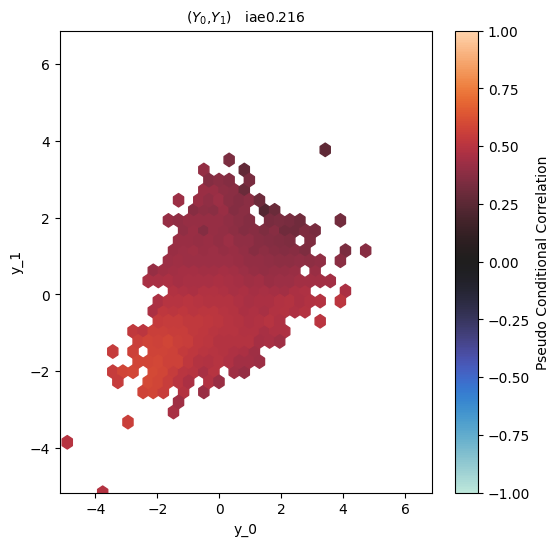

In [25]:
model.plot_conditional_dependence_structure(data=synthetic_samples,
                          dependence_metric_threshholding="iae",
                          minimum_dependence_threshold=0.2, 
                          )

In [26]:
# model.plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])

The splines of the model, 10 transformation layer splines and 3 x 45 decorrelation layer splines can also be plotted.

In [27]:
#model.plot_splines(layer_type="transformation")

In [28]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

In [29]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

In [30]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)

### 6. Identifying the Conditional Independence Graph

We compare the true known conditional independence Graph to the one learned by the GTM. To do so we first merge the true structure table with our learned one.

In [31]:
merged_ci_tables = pd.merge(
    conditional_independence_table,
    df_true_structure_sub,
    on=["var_row", "var_col"]
)


take a look at the table and sort by some idicator such as iae.

In [32]:
#merged_ci_tables.sort_values("iae",ascending=False) 

with the spearman and pearson correlations one can see how similar the metrics are and how strongly correlated they are to the dependence.

In [33]:
merged_ci_tables.corr("spearman") #"pearson"

,index,var_row,var_col,precision_abs_mean,precision_square_mean,cond_correlation_abs_mean,cond_correlation_square_mean,kld,iae,dependence
index,1.000000,0.977008,0.642034,-0.179221,-0.157143,-0.189610,-0.189610,-0.070130,-0.136364,0.204697
var_row,0.977008,1.000000,0.471429,-0.225975,-0.204042,-0.248572,-0.249237,-0.144225,-0.198725,0.169223
var_col,0.642034,0.471429,1.000000,0.093048,0.105676,0.128939,0.127609,0.266517,0.176792,0.249805
precision_abs_mean,-0.179221,-0.225975,0.093048,1.000000,0.996104,0.950649,0.961039,0.929870,0.959740,0.614091
precision_square_mean,-0.157143,-0.204042,0.105676,0.996104,1.000000,0.946753,0.959740,0.937662,0.959740,0.645583
cond_correlation_abs_mean,-0.189610,-0.248572,0.128939,0.950649,0.946753,1.000000,0.994805,0.940260,0.971429,0.472377
cond_correlation_square_mean,-0.189610,-0.249237,0.127609,0.961039,0.959740,0.994805,1.000000,0.955844,0.983117,0.503869
kld,-0.070130,-0.144225,0.266517,0.929870,0.937662,0.940260,0.955844,1.000000,0.968831,0.598345
iae,-0.136364,-0.198725,0.176792,0.959740,0.959740,0.971429,0.983117,0.968831,1.000000,0.551107
dependence,0.204697,0.169223,0.249805,0.614091,0.645583,0.472377,0.503869,0.598345,0.551107,1.000000


however the proper metric as identifying full conditional independence is a classification task is the AUC (Area under the ROC-Curve).

In [34]:
auc_iae = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["iae"])
auc_kld = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["kld"])
auc_corr = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["cond_correlation_abs_mean"])
auc_pmat = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["precision_abs_mean"])
print("AUC IAE                    :",auc_iae)
print("AUC KLD                    :",auc_kld)
print("AUC Conditional Correlation:",auc_corr)
print("AUC Precision Matrix       :",auc_pmat)

AUC IAE                    : 0.8181818181818181
AUC KLD                    : 0.8454545454545455
AUC Conditional Correlation: 0.7727272727272727
AUC Precision Matrix       : 0.8545454545454545


We further print the ROC Curves for different metrics.

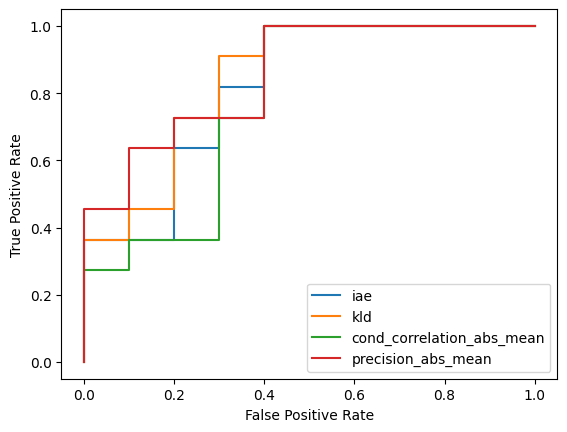

In [35]:
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["iae"])
plt.plot(fpr, tpr, label="iae")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["kld"])
plt.plot(fpr, tpr, label="kld")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["cond_correlation_abs_mean"])
plt.plot(fpr, tpr, label="cond_correlation_abs_mean")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["precision_abs_mean"])
plt.plot(fpr, tpr, label="precision_abs_mean")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()